First, install all necessary package and import all libraries:

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
!pip install -U xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib

## Read data

In [ ]:
df = pd.read_csv('/content/SciData_STEM (1).csv')
pd.set_option('display.max_columns', None)

## Data profiling

This study analyses school-based data from a public article of Vuong et. al (2021) of Vietnam, covering junior high school student records from  December 2017 and January 2018 across various disciplines. The dataset comprises 4,966 records with 42 independent variables, encompassing five major categories: 1) students’ personal information (including STEM performance), 2) family-related information, 3) book reading preferences, 4) book reading frequency/
habits, and 5) classroom activities.

In [ ]:
#Checking 5 first rows of data
df.head()

,q_FormDataId,q_63,q_83,School,Grade,Sex,APS45,APSVNEN,RankingF,NumberofChi,Readbook,Topic,FutureJob_VN,FutureJob_VN (translated),CareerFat,CareerFat (translated),CarFatGr,AgeFat,EduFat,CareerMot,CareerMot (translated),CarMotGr,AgeMot,EduMot,EcoStt,KnowledgeInc,EstIncome,Buybook,Hobby,TimeSci,TimeSoc,Readstory,Typebook,Typebook_Other,Reason,Source,PrioAct,AftAct,Read_like,EncourAct,MostlikedAct,Bookcase,Notread_like
0,4,13,43075,2,8.0,Female,7.00,0.0,3,4,yes,e,bác sĩ,Doctor,làm ruộng,Farmer,Labor,48.0,UnderHi,Công nhân,Worker,Labor,40.0,UnderHi,med,no,NaN,yes,a,2,2.0,no,c,NaN,a,buy,a,b,Thám tử lừng danh Cô nan\r\nShin Cậu bé bút chì,yes,b,d,Lão Hạc\r\nAlibaba và 40 tên cướp\r\nCây đèn thần
1,5,6225,43074,3,9.0,NaN,0.00,0.0,0,0,yes,d,Họa sĩ,Painter,Công an,Police officer,Labor,NaN,Uni,Giáo viên,Teacher,Intellectuals,NaN,Uni,rich,no,NaN,yes,b,2,1.0,yes,d,NaN,a,buy,c,a,NaN,yes,d,c,NaN
2,6,6226,43074,3,9.0,Female,6.50,0.0,1,2,yes,b,Thợ may,Worker,Làm ruộng,Farmer,Labor,NaN,Hi,Làm ruộng,Farmer,Labor,NaN,Hi,med,no,NaN,yes,c,2,1.0,NaN,a,NaN,a,buy,a,a,Truyện Conan\r\nTruyện Kiều,NaN,b,a,Quà tặng cuộc sống\r\nTắt đèn\r\nTruyện Kiều
3,7,6228,43074,3,9.0,Female,8.50,0.0,1,2,yes,d,Công nhân viên chức,Public servant,Công nhân,Worker,Labor,41.0,Hi,Công nhân,Worker,Labor,40.0,Hi,med,no,8000000,yes,b,1,1.0,NaN,c,NaN,a,buy,d,a,400 bài tập hóa học\r\nBài tập nâng cao toán 9,yes,a,d,NaN
4,8,6229,43074,3,9.0,Female,9.75,0.0,2,3,yes,d,Vận động viên,Athlete,Làm ruộng,Farmer,Labor,38.0,UnderHi,Làm ruộng,Farmer,Labor,36.0,UnderHi,med,no,NaN,yes,b,1,1.0,no,a,NaN,a,borrow,a,b,NaN,yes,d,d,NaN


In [ ]:
#Checking initial information of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q_FormDataId               4966 non-null   int64  
 1   q_63                       4966 non-null   object 
 2   q_83                       4863 non-null   object 
 3   School                     4966 non-null   int64  
 4   Grade                      4884 non-null   float64
 5   Sex                        4915 non-null   object 
 6   APS45                      4957 non-null   float64
 7   APSVNEN                    4966 non-null   float64
 8   RankingF                   4966 non-null   int64  
 9   NumberofChi                4966 non-null   int64  
 10  Readbook                   4776 non-null   object 
 11  Topic                      4644 non-null   object 
 12  FutureJob_VN               4887 non-null   object 
 13  FutureJob_VN (translated)  4662 non-null   objec

In [ ]:
#Print the percentage of missing value in all columns
print((df.isna().sum() * 100 / len(df)).sort_values(ascending=False).head(20))

EstIncome                    90.998792
Typebook_Other               86.387435
AgeMot                        9.484495
AgeFat                        9.403947
EduFat                        9.021345
Notread_like                  7.450665
EduMot                        7.188884
MostlikedAct                  6.886830
Topic                         6.484092
KnowledgeInc                  6.363270
FutureJob_VN (translated)     6.121627
Readstory                     5.879984
Readbook                      3.826017
CareerFat (translated)        3.604511
TimeSoc                       3.463552
CarFatGr                      3.242046
EncourAct                     3.221909
EcoStt                        3.020540
Bookcase                      2.919855
Buybook                       2.456706
dtype: float64


-> After looking all missing columns, the EstIncome and Typebook_Other can be dropped since the percentage of missing value is high (more than 80%).

Next, each record needs to be categorised as different levels based on student's performance (in this case, the points generated from APSVNEN and APS45, then create labels based on the points level).

In [ ]:
# Make a funtion to combine score from (APSVNEN and APS45).
# The method to combine is if the there is only 1 value from midterm and min45, take only that value, and if there are 2 values, take the min45 x 2 and midterm x 3, then divided by 5
def calculate_point(midterm, min45):
  if midterm > 0 and min45 == 0:
    return midterm
  if midterm == 0 and min45 > 0:
    return min45
  return (midterm * 3 + min45 * 2) / 5

In [ ]:
# Create a new column "Points"
df['Points'] = df.apply(lambda row: calculate_point(row['APSVNEN'], row['APS45']), axis=1)

In [ ]:
 # Sorting the level based on Points
 def create_label(point):
  if point >= 8:
    return 3
  if point >= 6.5:
    return 2
  if point >= 5:
    return 1
  return 0

In [ ]:
# Create a label column
df['label'] = df['Points'].apply(create_label)

In [ ]:
df

,q_FormDataId,q_63,q_83,School,Grade,Sex,APS45,APSVNEN,RankingF,NumberofChi,Readbook,Topic,FutureJob_VN,FutureJob_VN (translated),CareerFat,CareerFat (translated),CarFatGr,AgeFat,EduFat,CareerMot,CareerMot (translated),CarMotGr,AgeMot,EduMot,EcoStt,KnowledgeInc,EstIncome,Buybook,Hobby,TimeSci,TimeSoc,Readstory,Typebook,Typebook_Other,Reason,Source,PrioAct,AftAct,Read_like,EncourAct,MostlikedAct,Bookcase,Notread_like,Points,label
0,4,13,43075,2,8.0,Female,7.00,0.0,3,4,yes,e,bác sĩ,Doctor,làm ruộng,Farmer,Labor,48.0,UnderHi,Công nhân,Worker,Labor,40.0,UnderHi,med,no,NaN,yes,a,2,2.0,no,c,NaN,a,buy,a,b,Thám tử lừng danh Cô nan\r\nShin Cậu bé bút chì,yes,b,d,Lão Hạc\r\nAlibaba và 40 tên cướp\r\nCây đèn thần,7.00,2
1,5,6225,43074,3,9.0,NaN,0.00,0.0,0,0,yes,d,Họa sĩ,Painter,Công an,Police officer,Labor,NaN,Uni,Giáo viên,Teacher,Intellectuals,NaN,Uni,rich,no,NaN,yes,b,2,1.0,yes,d,NaN,a,buy,c,a,NaN,yes,d,c,NaN,0.00,0
2,6,6226,43074,3,9.0,Female,6.50,0.0,1,2,yes,b,Thợ may,Worker,Làm ruộng,Farmer,Labor,NaN,Hi,Làm ruộng,Farmer,Labor,NaN,Hi,med,no,NaN,yes,c,2,1.0,NaN,a,NaN,a,buy,a,a,Truyện Conan\r\nTruyện Kiều,NaN,b,a,Quà tặng cuộc sống\r\nTắt đèn\r\nTruyện Kiều,6.50,2
3,7,6228,43074,3,9.0,Female,8.50,0.0,1,2,yes,d,Công nhân viên chức,Public servant,Công nhân,Worker,Labor,41.0,Hi,Công nhân,Worker,Labor,40.0,Hi,med,no,8000000,yes,b,1,1.0,NaN,c,NaN,a,buy,d,a,400 bài tập hóa học\r\nBài tập nâng cao toán 9,yes,a,d,NaN,8.50,3
4,8,6229,43074,3,9.0,Female,9.75,0.0,2,3,yes,d,Vận động viên,Athlete,Làm ruộng,Farmer,Labor,38.0,UnderHi,Làm ruộng,Farmer,Labor,36.0,UnderHi,med,no,NaN,yes,b,1,1.0,no,a,NaN,a,borrow,a,b,NaN,yes,d,d,NaN,9.75,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4961,4965,7.293,43071,7,8.0,Female,7.00,0.0,2,2,yes,b,Vận động viên bóng chuyền,Volleyball player,Nông dân,Farmer,Labor,38.0,UnderHi,Công nhân,Worker,Labor,38.0,UnderHi,med,no,NaN,yes,a,1,1.0,no,NaN,NaN,a,borrow,a,d,Conan\r\nDoraemon,yes,b,d,NaN,7.00,2
4962,4966,7.294,43071,7,8.0,Male,5.00,0.0,2,2,no,NaN,Thợ xây,Worker,Thợ xây,Worker,Labor,38.0,UnderHi,Nông dân,Farmer,Labor,35.0,UnderHi,med,no,NaN,yes,c,3,1.0,no,a,NaN,d,borrow,d,b,7 viên ngọc rồng\r\nNàng tiên cá,yes,a,b,Doraemon\r\nConan,5.00,1
4963,4967,7.295,43071,7,8.0,Female,7.30,0.0,1,2,yes,c,Họa sĩ,Painter,Nông dân,Farmer,Labor,33.0,UnderHi,Nông dân,Farmer,Labor,33.0,UnderHi,med,no,NaN,yes,d,1,1.0,no,d,NaN,a,buy,d,d,Thần đồng đất Việt\r\nDoraemon,no,d,d,Cậu bé bút chì\r\nCó thể em chưa biết,7.30,2
4964,4968,7.296,43071,7,8.0,Female,7.00,0.0,1,2,yes,b,Bác sĩ,Doctor,Nông dân,Farmer,Labor,36.0,UnderHi,Nông dân,Farmer,Labor,30.0,UnderHi,med,no,NaN,yes,e,1,1.0,no,NaN,NaN,a,borrow,a,d,NaN,yes,d,d,NaN,7.00,2


In [ ]:
df.columns

Index(['q_FormDataId', 'q_63', 'q_83', 'School', 'Grade', 'Sex', 'APS45',
       'APSVNEN', 'RankingF', 'NumberofChi', 'Readbook', 'Topic',
       'FutureJob_VN', 'FutureJob_VN (translated)', 'CareerFat',
       'CareerFat (translated)', 'CarFatGr', 'AgeFat', 'EduFat', 'CareerMot',
       'CareerMot (translated)', 'CarMotGr', 'AgeMot', 'EduMot', 'EcoStt',
       'KnowledgeInc', 'EstIncome', 'Buybook', 'Hobby', 'TimeSci', 'TimeSoc',
       'Readstory', 'Typebook', 'Typebook_Other', 'Reason', 'Source',
       'PrioAct', 'AftAct', 'Read_like', 'EncourAct', 'MostlikedAct',
       'Bookcase', 'Notread_like', 'Points', 'label'],
      dtype='object')

In [ ]:
df.drop(['q_FormDataId', 'q_63', 'q_83', 'FutureJob_VN', "CareerFat", "CareerMot", "Read_like", "Notread_like", 'APS45', "APSVNEN"], axis=1, inplace=True)

After checking all columns, I decided to drop the not related columns and Vietnamese columns.

In [ ]:
df.head(10)

,School,Grade,Sex,RankingF,NumberofChi,Readbook,Topic,FutureJob_VN (translated),CareerFat (translated),CarFatGr,AgeFat,EduFat,CareerMot (translated),CarMotGr,AgeMot,EduMot,EcoStt,KnowledgeInc,EstIncome,Buybook,Hobby,TimeSci,TimeSoc,Readstory,Typebook,Typebook_Other,Reason,Source,PrioAct,AftAct,EncourAct,MostlikedAct,Bookcase,Points,label
0,2,8.0,Female,3,4,yes,e,Doctor,Farmer,Labor,48.0,UnderHi,Worker,Labor,40.0,UnderHi,med,no,NaN,yes,a,2,2.0,no,c,NaN,a,buy,a,b,yes,b,d,7.00,2
1,3,9.0,NaN,0,0,yes,d,Painter,Police officer,Labor,NaN,Uni,Teacher,Intellectuals,NaN,Uni,rich,no,NaN,yes,b,2,1.0,yes,d,NaN,a,buy,c,a,yes,d,c,0.00,0
2,3,9.0,Female,1,2,yes,b,Worker,Farmer,Labor,NaN,Hi,Farmer,Labor,NaN,Hi,med,no,NaN,yes,c,2,1.0,NaN,a,NaN,a,buy,a,a,NaN,b,a,6.50,2
3,3,9.0,Female,1,2,yes,d,Public servant,Worker,Labor,41.0,Hi,Worker,Labor,40.0,Hi,med,no,8000000,yes,b,1,1.0,NaN,c,NaN,a,buy,d,a,yes,a,d,8.50,3
4,3,9.0,Female,2,3,yes,d,Athlete,Farmer,Labor,38.0,UnderHi,Farmer,Labor,36.0,UnderHi,med,no,NaN,yes,b,1,1.0,no,a,NaN,a,borrow,a,b,yes,d,d,9.75,3
5,3,9.0,Male,1,2,yes,e,Teacher,Farmer,Labor,55.0,PostGrad,Farmer,Labor,40.0,UnderHi,med,no,NaN,yes,b,2,2.0,no,c,NaN,a,buy,d,a,yes,c,b,0.00,0
6,3,9.0,Female,2,2,yes,d,Doctor,Worker,Labor,45.0,UnderHi,Worker,Labor,39.0,UnderHi,med,no,NaN,yes,b,2,2.0,yes,b,NaN,a,borrow,a,b,yes,b,b,7.00,2
7,3,9.0,Female,1,2,yes,b,Doctor,Farmer,Labor,34.0,Hi,Farmer,Labor,32.0,Hi,med,no,NaN,yes,f,2,2.0,yes,a,NaN,a,buy,b,d,yes,d,d,8.00,3
8,3,9.0,Female,4,4,yes,b,Teacher,Farmer,Labor,47.0,UnderHi,Farmer,Labor,45.0,UnderHi,med,no,NaN,yes,c,1,2.0,yes,a,NaN,a,buy,b,a,yes,a,d,8.00,3
9,2,8.0,Female,1,2,yes,d,Doctor,Worker,Labor,32.0,Hi,Worker,Labor,32.0,Hi,med,no,NaN,yes,b,1,1.0,no,c,NaN,a,borrow,a,a,yes,a,d,6.00,1


In [ ]:
df = df.rename(columns={'FutureJob_VN (translated)': 'FutureJob', 'CareerFat (translated)': 'CareerFat', 'CareerMot (translated)': 'CareerMot'})

#### Columns may want to discard
- All columns in Vietnamese and data ID as it is not likely going to affect any of this analyses.
- Columns that have many missing value (Estimated Income and Typebook_Other)

### Columns where may want to simplify the data
- Combine 2 columns APS45 and APSVNEN and create a new Points column
- Sorting level based on the Points


In [ ]:
df.head(10)

,School,Grade,Sex,RankingF,NumberofChi,Readbook,Topic,FutureJob,CareerFat,CarFatGr,AgeFat,EduFat,CareerMot,CarMotGr,AgeMot,EduMot,EcoStt,KnowledgeInc,EstIncome,Buybook,Hobby,TimeSci,TimeSoc,Readstory,Typebook,Typebook_Other,Reason,Source,PrioAct,AftAct,EncourAct,MostlikedAct,Bookcase,Points,label
0,2,8.0,Female,3,4,yes,e,Doctor,Farmer,Labor,48.0,UnderHi,Worker,Labor,40.0,UnderHi,med,no,NaN,yes,a,2,2.0,no,c,NaN,a,buy,a,b,yes,b,d,7.00,2
1,3,9.0,NaN,0,0,yes,d,Painter,Police officer,Labor,NaN,Uni,Teacher,Intellectuals,NaN,Uni,rich,no,NaN,yes,b,2,1.0,yes,d,NaN,a,buy,c,a,yes,d,c,0.00,0
2,3,9.0,Female,1,2,yes,b,Worker,Farmer,Labor,NaN,Hi,Farmer,Labor,NaN,Hi,med,no,NaN,yes,c,2,1.0,NaN,a,NaN,a,buy,a,a,NaN,b,a,6.50,2
3,3,9.0,Female,1,2,yes,d,Public servant,Worker,Labor,41.0,Hi,Worker,Labor,40.0,Hi,med,no,8000000,yes,b,1,1.0,NaN,c,NaN,a,buy,d,a,yes,a,d,8.50,3
4,3,9.0,Female,2,3,yes,d,Athlete,Farmer,Labor,38.0,UnderHi,Farmer,Labor,36.0,UnderHi,med,no,NaN,yes,b,1,1.0,no,a,NaN,a,borrow,a,b,yes,d,d,9.75,3
5,3,9.0,Male,1,2,yes,e,Teacher,Farmer,Labor,55.0,PostGrad,Farmer,Labor,40.0,UnderHi,med,no,NaN,yes,b,2,2.0,no,c,NaN,a,buy,d,a,yes,c,b,0.00,0
6,3,9.0,Female,2,2,yes,d,Doctor,Worker,Labor,45.0,UnderHi,Worker,Labor,39.0,UnderHi,med,no,NaN,yes,b,2,2.0,yes,b,NaN,a,borrow,a,b,yes,b,b,7.00,2
7,3,9.0,Female,1,2,yes,b,Doctor,Farmer,Labor,34.0,Hi,Farmer,Labor,32.0,Hi,med,no,NaN,yes,f,2,2.0,yes,a,NaN,a,buy,b,d,yes,d,d,8.00,3
8,3,9.0,Female,4,4,yes,b,Teacher,Farmer,Labor,47.0,UnderHi,Farmer,Labor,45.0,UnderHi,med,no,NaN,yes,c,1,2.0,yes,a,NaN,a,buy,b,a,yes,a,d,8.00,3
9,2,8.0,Female,1,2,yes,d,Doctor,Worker,Labor,32.0,Hi,Worker,Labor,32.0,Hi,med,no,NaN,yes,b,1,1.0,no,c,NaN,a,borrow,a,a,yes,a,d,6.00,1


## Fill null values

In [ ]:
# drop 2 columns:  Estimated Income and Typebook_Other
df.drop(['EstIncome', 'Typebook_Other'], axis=1, inplace=True)

After dropping columns, I divided data into 2 lists: numeric_columns and object_columns, but excluding a column named 'label'.

In [ ]:
numeric_columns = [x for x in df.columns if df[x].dtype != 'object' and x != 'label']
object_columns = [x for x in df.columns if df[x].dtype == 'object' and x != 'label']

Next, the missing values in numeric columns are addressed by filling them with the most frequently occurring value (mode) and ensures the columns are of integer data type afterward.

In [ ]:
# numeric columns: fill na by mode value
for col in numeric_columns:
  if df[col].isna().sum() > 0:
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].astype('int64')

<ipython-input-22-ab98f6dd9dd9>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
<ipython-input-22-ab98f6dd9dd9>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Them, missing values in categorical columns are filled with the most frequently occurring value (mode), ensuring that the data remains consistent and complete for further analysis.

In [ ]:
# object columns: fill na by mode value
for col in object_columns:
  if df[col].isna().sum() > 0:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-23-52990bdb3577>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Separating numerical and categorical data is also a crucial step for effective data analysis, machine learning model preparation, and selection. After this step, the missing values in numeric columns are addressed by filling them with the most frequently occurring value (mode) and ensures the columns are of integer data type afterward. Then, missing values in categorical columns are filled with the most frequently occurring value (mode), ensuring that the data remains consistent and complete for further analysis.

## Variables analysis

#### a. Numeric variables

The next phase involves data mapping to enhance visualisation and insight generation. Visualising the "label" column with other variables using bar plots helps identify predictive relationships, provides insights into the dataset's structure and the relative importance of different variables in predicting student outcomes.

In [ ]:
mapping_data = {
    'Topic': {
        'a': 'Mathematics/physics',
        'b': 'Literature',
        'c': 'Foreign language',
        'd': 'Natural science/chemistry/biology',
        'e': 'History/geography',
        'f': 'Information technology'
    },
     'Hobby': {
        'a': 'Reading books',
        'b': 'Watching TV/listening to music',
        'c': 'Housework/farming',
        'd': 'Observing nature',
        'e': 'Interacting with friends/family members',
        'f': 'Others'

    },
     'Typebook': {
        'a': 'Novel',
        'b': 'Biography',
        'c': 'Popular science',
        'd': 'Arts',
        'e': 'Vocational instruction',
        'f': 'Others'
    },
    'Reason': {
        'a': 'Personal preferences',
        'b': 'Recommended by parents',
        'c': 'Recommended by teachers/friends',
        'd': 'Serendipity',
    },
    'PrioAct': {
        'a': 'Sharing with friends/family',
        'b': 'Recording',
        'c': 'Applying the content to daily life',
        'd': 'Reflecting and relating to personal knowledge',
    },
    'AftAct': {
        'a': 'Finding more books on the exact issue',
        'b': 'Finding more books on the related issue',
        'c': 'Finding books on the new issue',
        'd': 'Reading the book again',
    },
     'MostlikedAct': {
        'a': 'Book exhibition',
        'b': 'Storytelling competition',
        'c': 'Story-writing competition',
        'd': 'Illustrating books’ content by drawing',
    },
    'Bookcase': {
        'a': 'Diverse and interesting',
        'b': 'Lack of good titles',
        'c': 'Lack of book',
        'd': 'No bookshelf',
    }
}

In [ ]:
for col in mapping_data:
     df[col] = df[col].map(mapping_data[col])

School


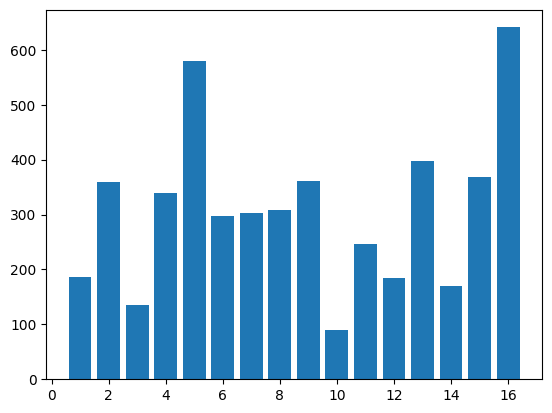

----------------------------------------------------------------------------------------------------
Grade


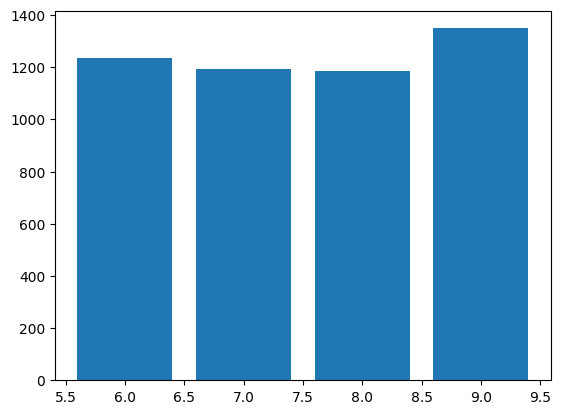

----------------------------------------------------------------------------------------------------
RankingF


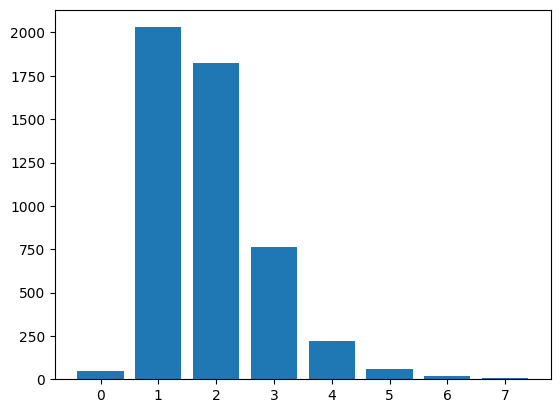

----------------------------------------------------------------------------------------------------
NumberofChi


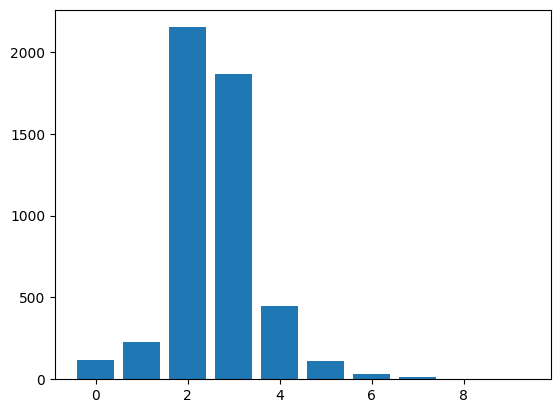

----------------------------------------------------------------------------------------------------
AgeFat


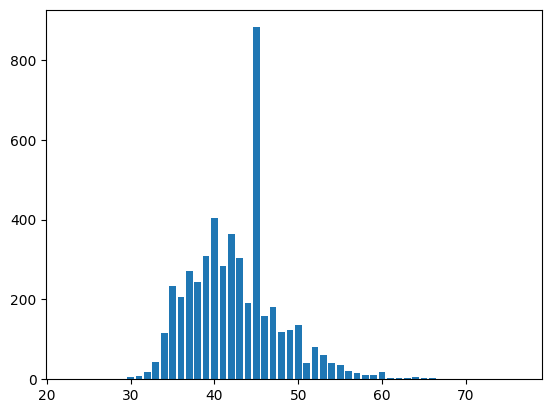

----------------------------------------------------------------------------------------------------
AgeMot


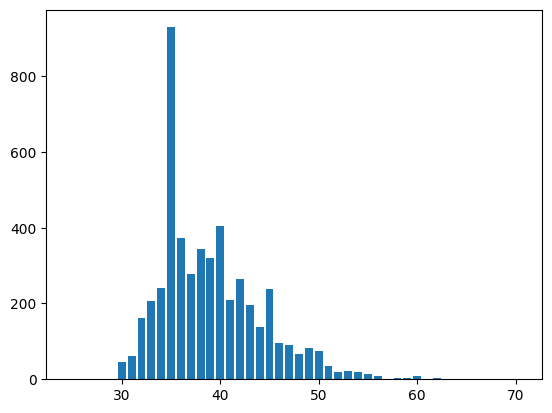

----------------------------------------------------------------------------------------------------
TimeSci


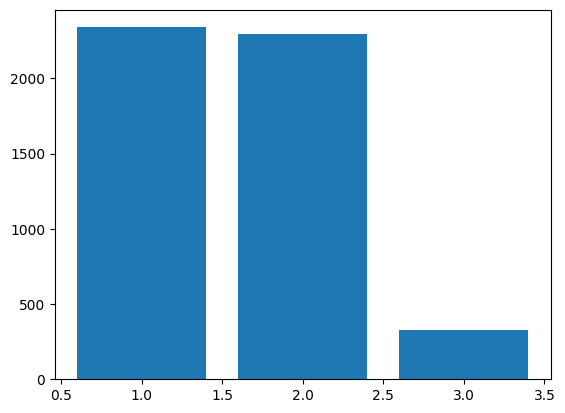

----------------------------------------------------------------------------------------------------
TimeSoc


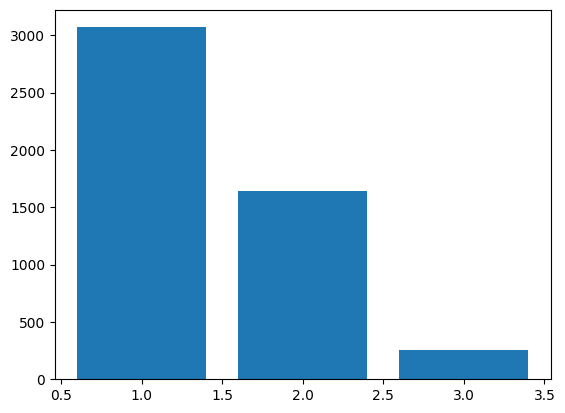

----------------------------------------------------------------------------------------------------
Points


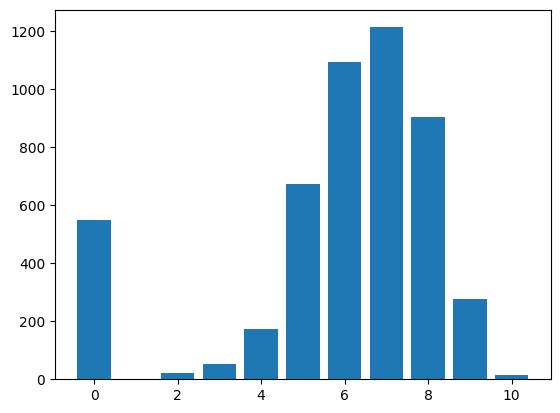

----------------------------------------------------------------------------------------------------


In [ ]:
#Drawing data with only numerical variables
for col in numeric_columns:
  print(col)
  tmp = df[[col, 'label']].groupby(col, as_index=False)['label'].count()
  plt.bar(tmp[col], tmp['label'])
  plt.show()
  print('-'*100)

#### b. Object variables

Sex


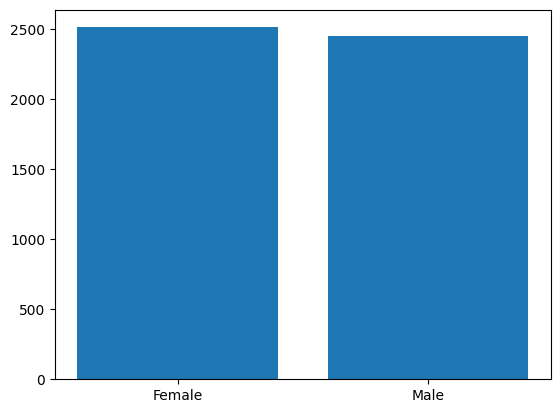

----------------------------------------------------------------------------------------------------
Readbook


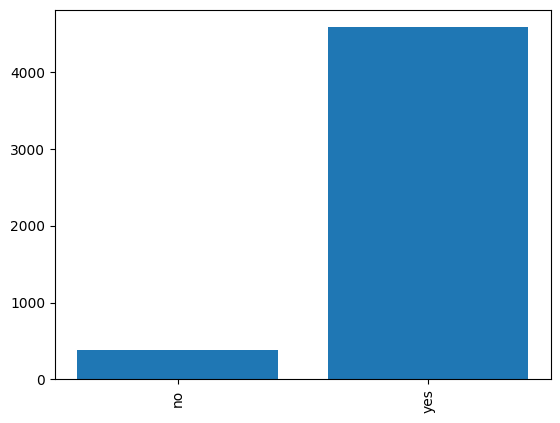

----------------------------------------------------------------------------------------------------
Topic


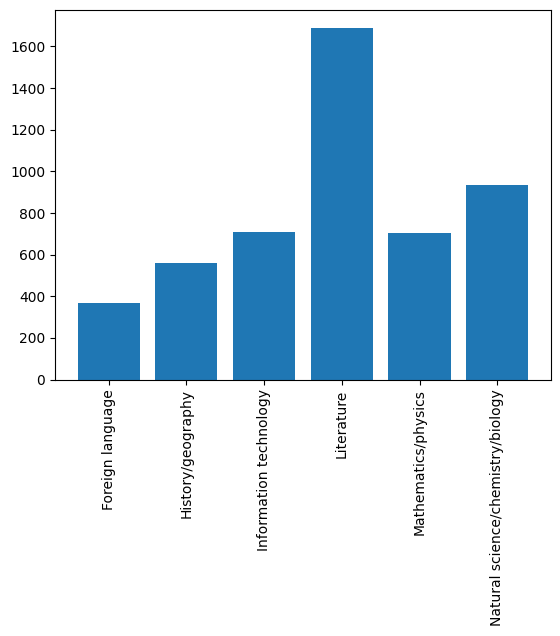

----------------------------------------------------------------------------------------------------
FutureJob


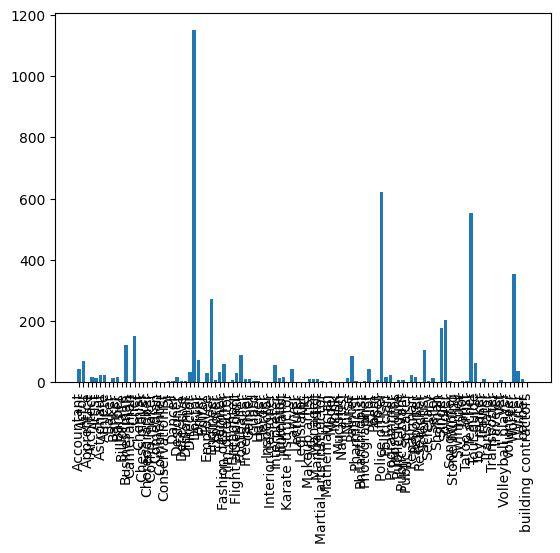

----------------------------------------------------------------------------------------------------
CareerFat


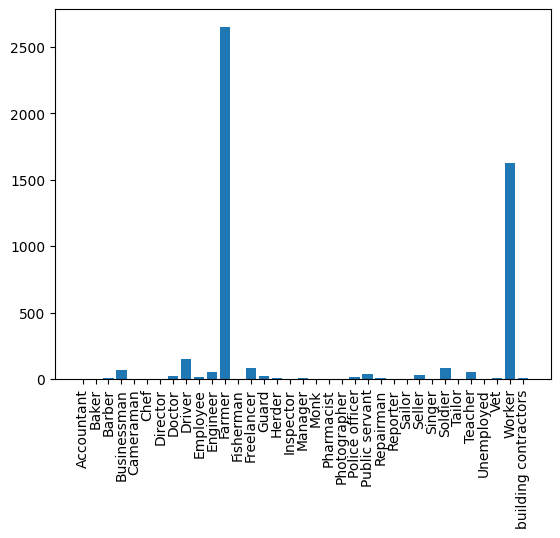

----------------------------------------------------------------------------------------------------
CarFatGr


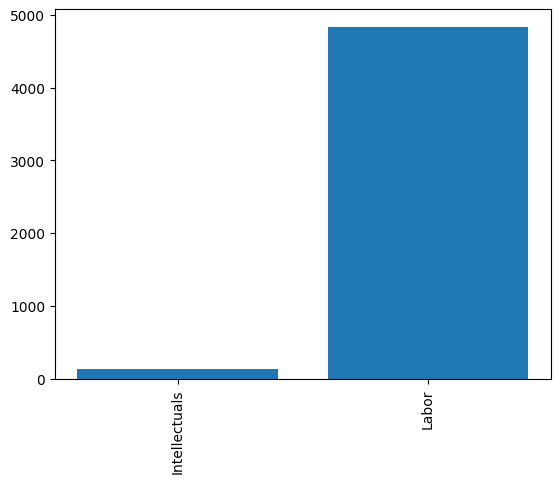

----------------------------------------------------------------------------------------------------
EduFat


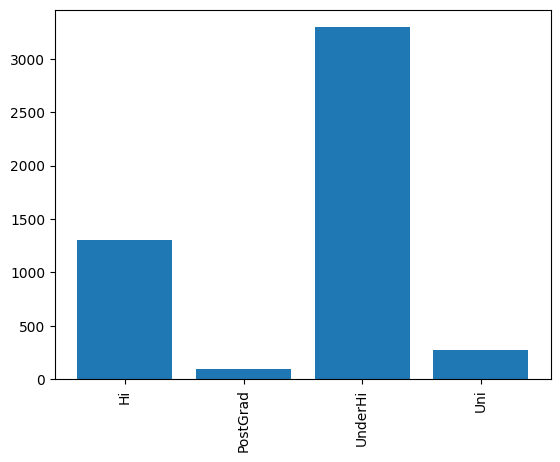

----------------------------------------------------------------------------------------------------
CareerMot


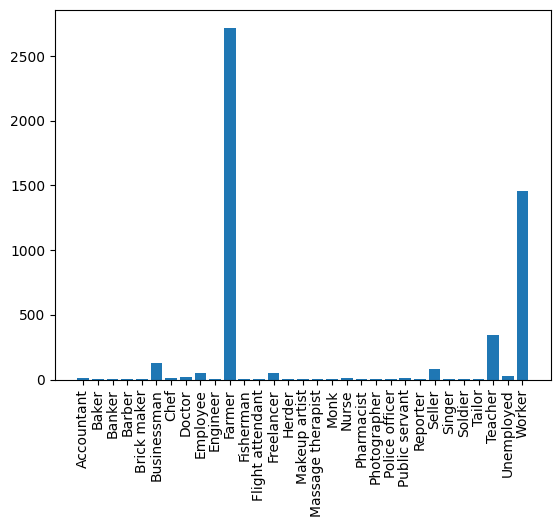

----------------------------------------------------------------------------------------------------
CarMotGr


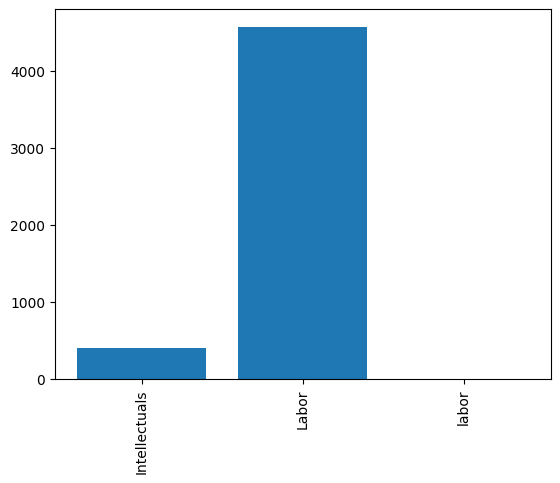

----------------------------------------------------------------------------------------------------
EduMot


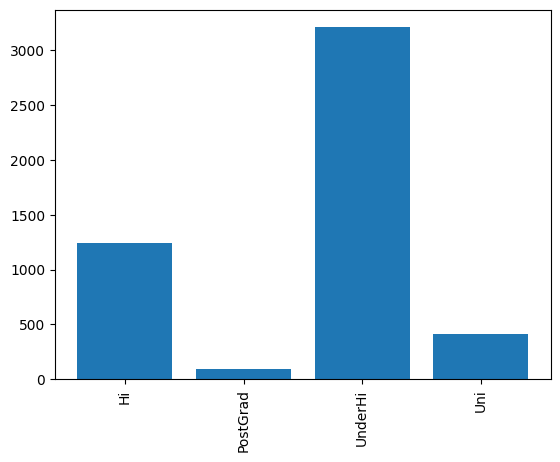

----------------------------------------------------------------------------------------------------
EcoStt


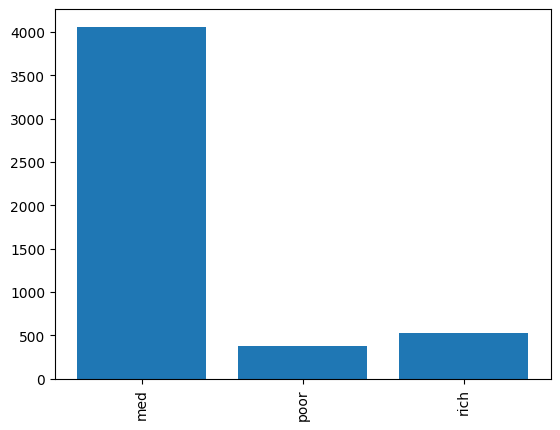

----------------------------------------------------------------------------------------------------
KnowledgeInc


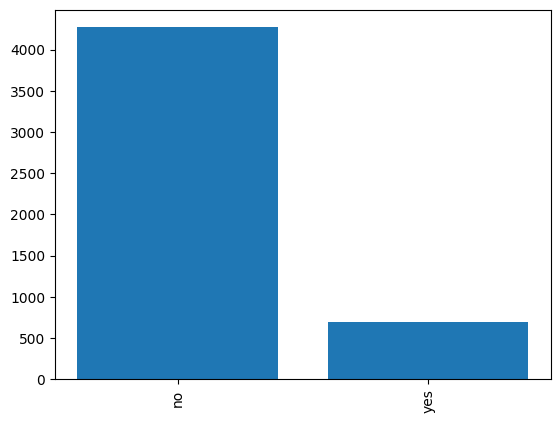

----------------------------------------------------------------------------------------------------
Buybook


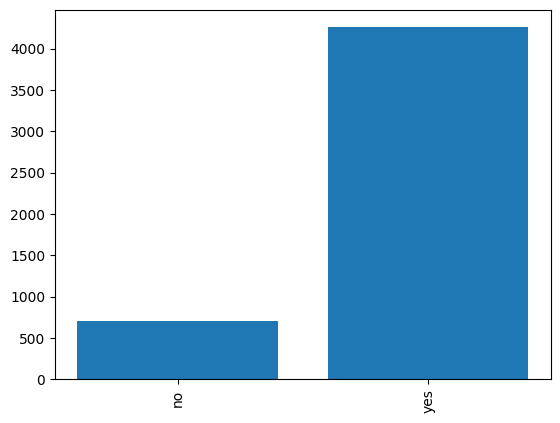

----------------------------------------------------------------------------------------------------
Hobby


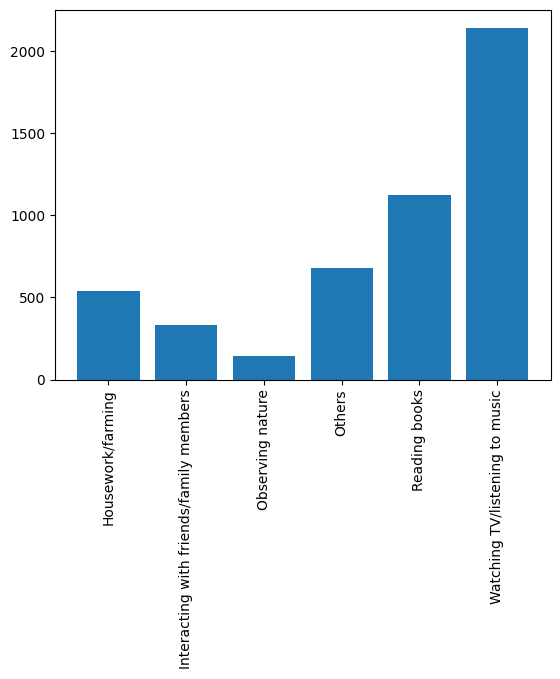

----------------------------------------------------------------------------------------------------
Readstory


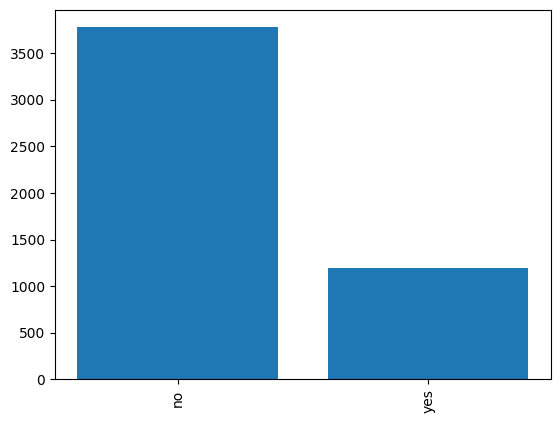

----------------------------------------------------------------------------------------------------
Typebook


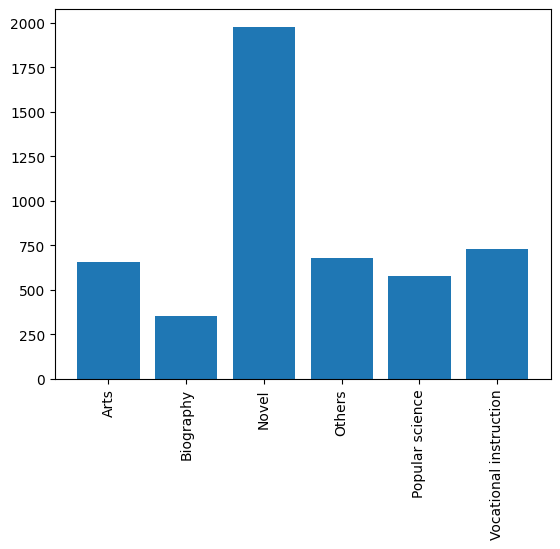

----------------------------------------------------------------------------------------------------
Reason


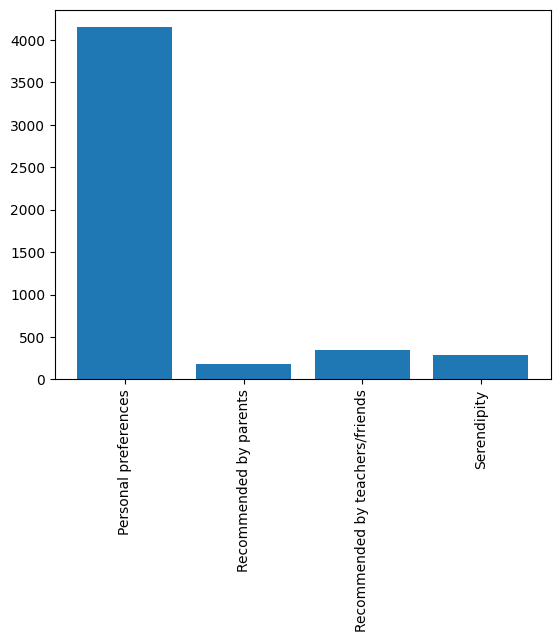

----------------------------------------------------------------------------------------------------
Source


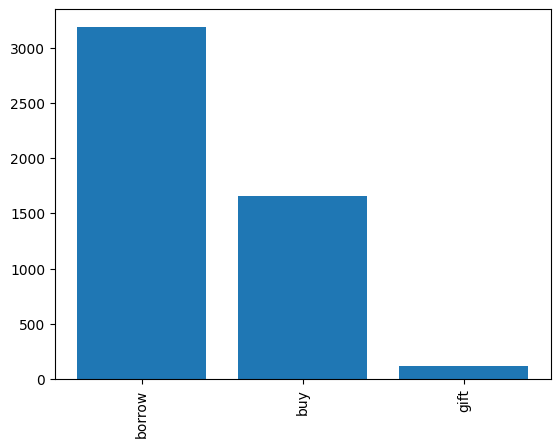

----------------------------------------------------------------------------------------------------
PrioAct


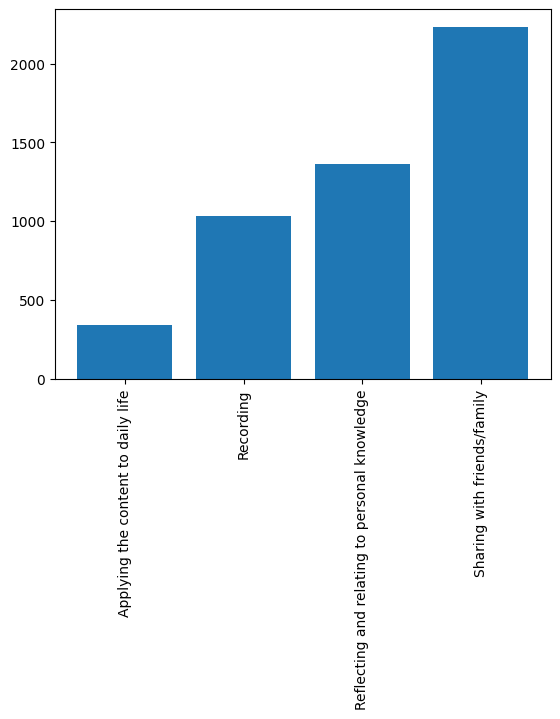

----------------------------------------------------------------------------------------------------
AftAct


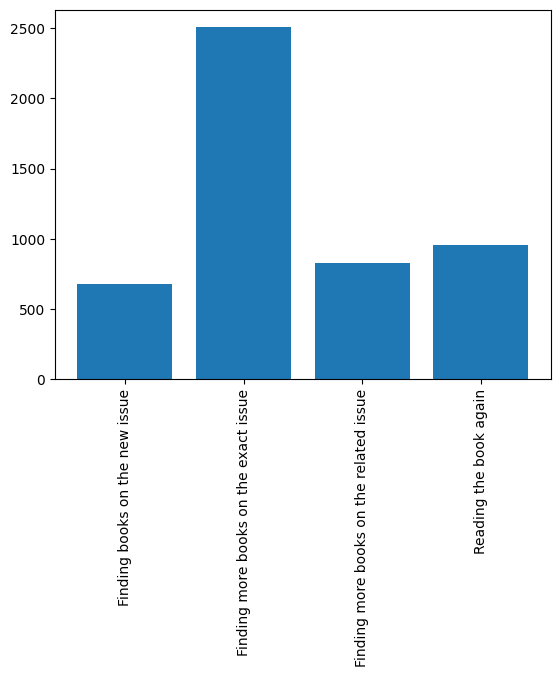

----------------------------------------------------------------------------------------------------
EncourAct


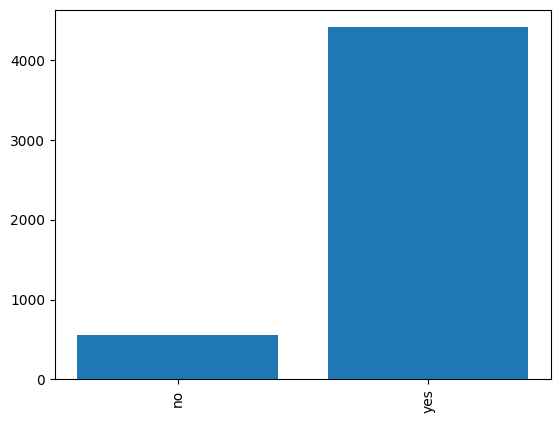

----------------------------------------------------------------------------------------------------
MostlikedAct


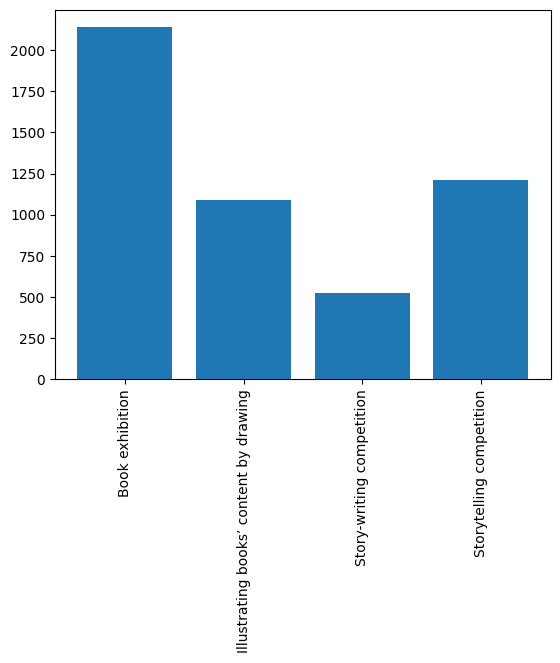

----------------------------------------------------------------------------------------------------
Bookcase


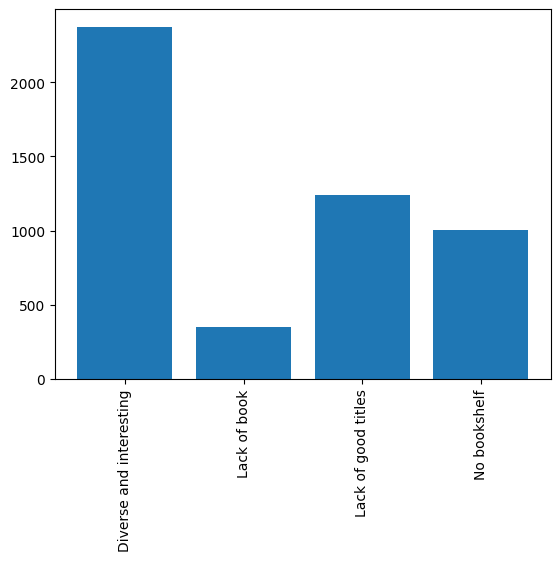

----------------------------------------------------------------------------------------------------


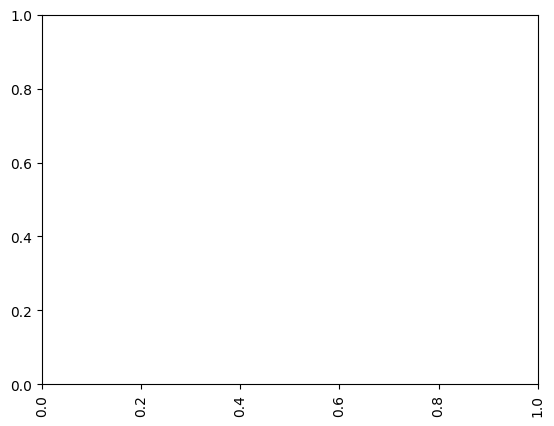

In [ ]:
#Drawing data with only object variables
for col in object_columns:
  print(col)
  tmp = df[[col, 'label']].groupby(col, as_index=False)['label'].count()
  # plt.figure(figsize=(15,10))
  plt.bar(tmp[col], tmp['label'])
  plt.show()
  plt.xticks(rotation=90)
  print('-'*100)

## Variable analysis for each label

#### a. Numeric columns

School


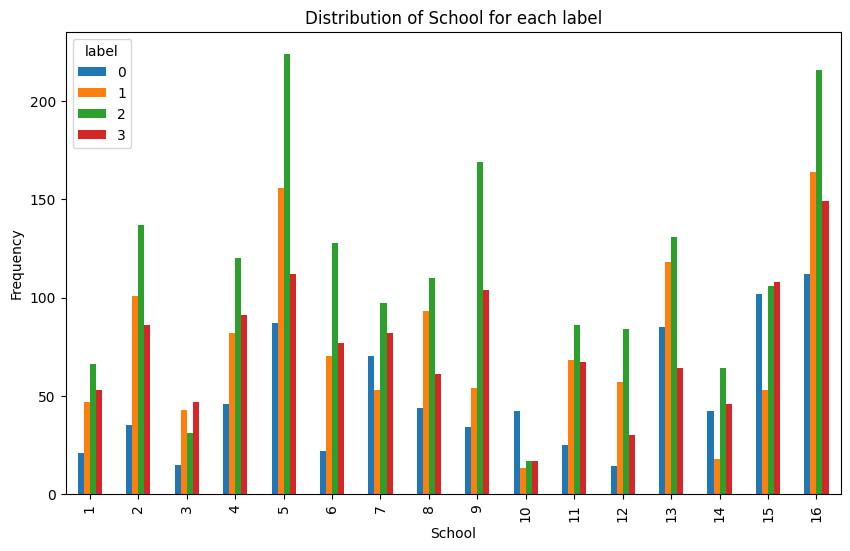

----------------------------------------------------------------------------------------------------
Grade


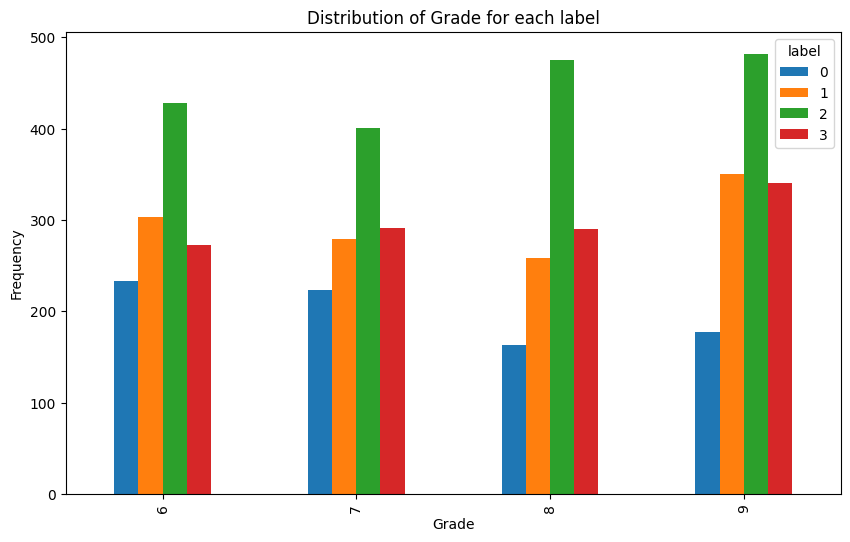

----------------------------------------------------------------------------------------------------
RankingF


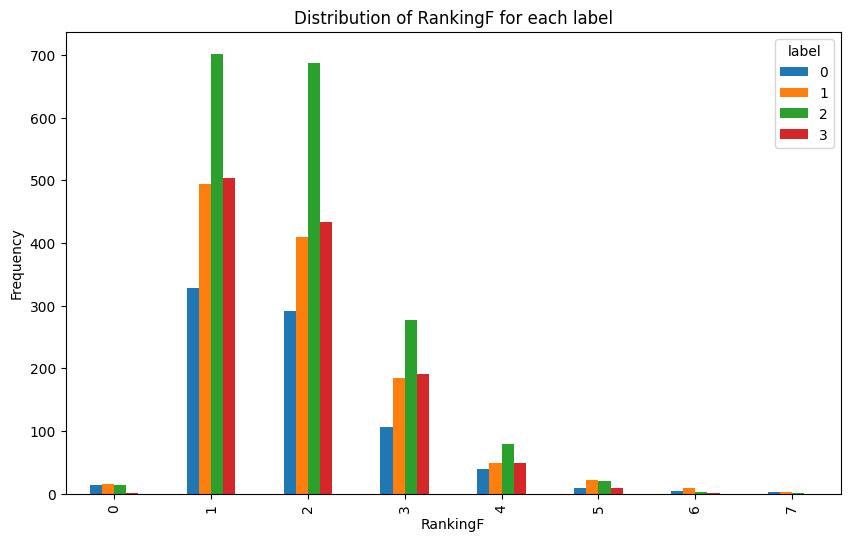

----------------------------------------------------------------------------------------------------
NumberofChi


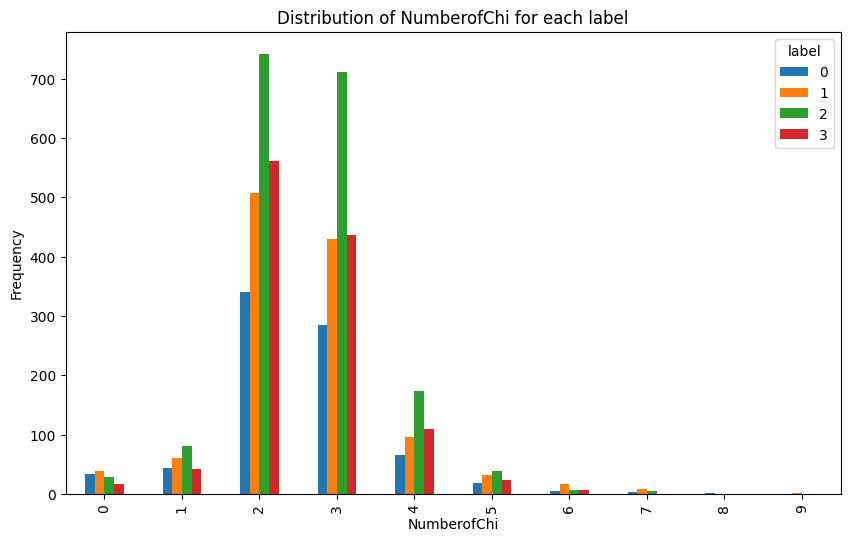

----------------------------------------------------------------------------------------------------
AgeFat


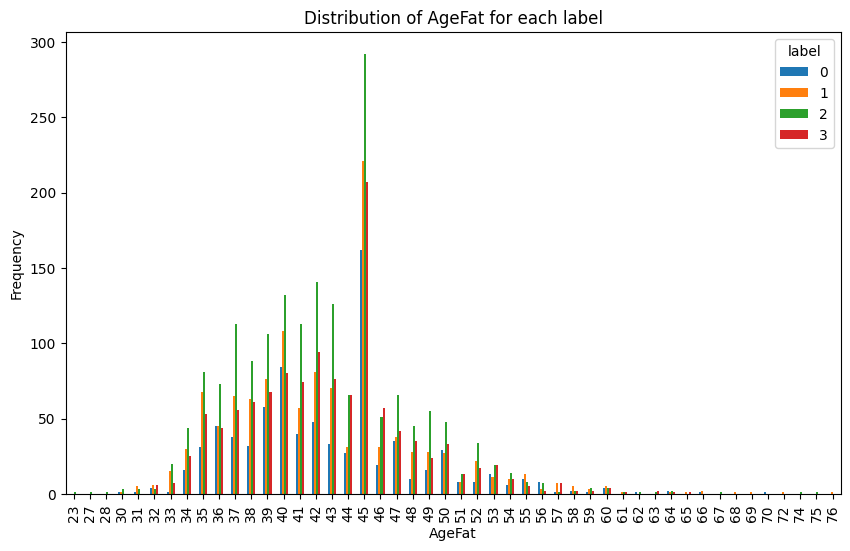

----------------------------------------------------------------------------------------------------
AgeMot


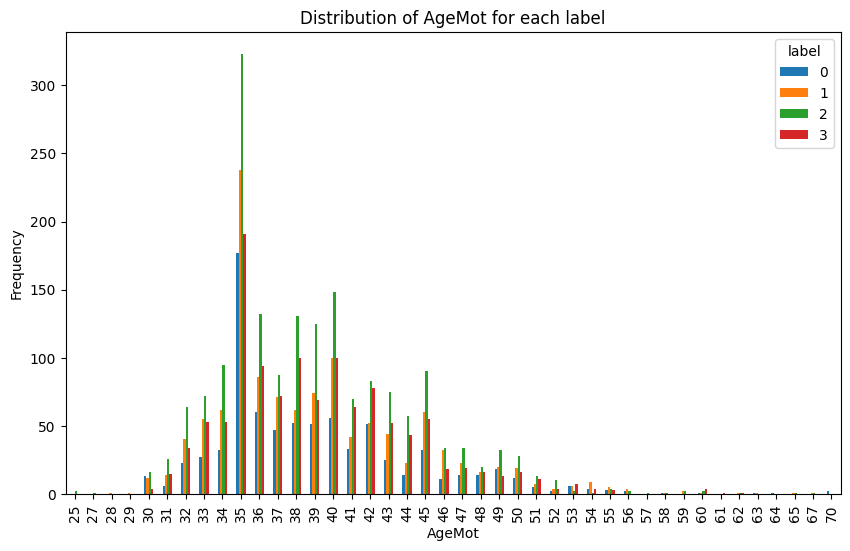

----------------------------------------------------------------------------------------------------
TimeSci


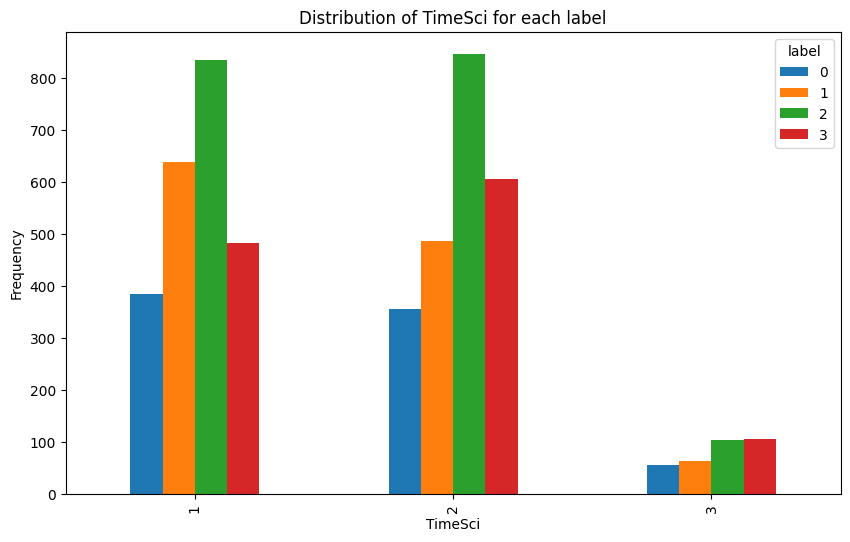

----------------------------------------------------------------------------------------------------
TimeSoc


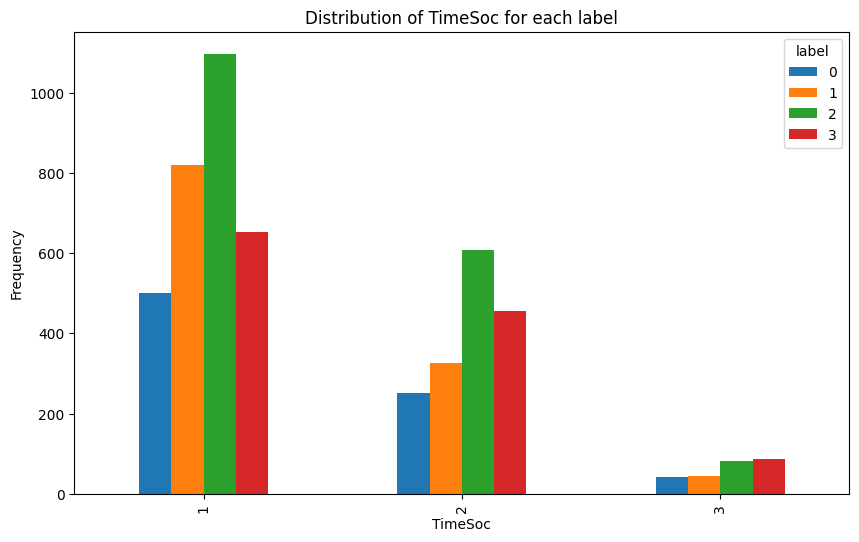

----------------------------------------------------------------------------------------------------
Points


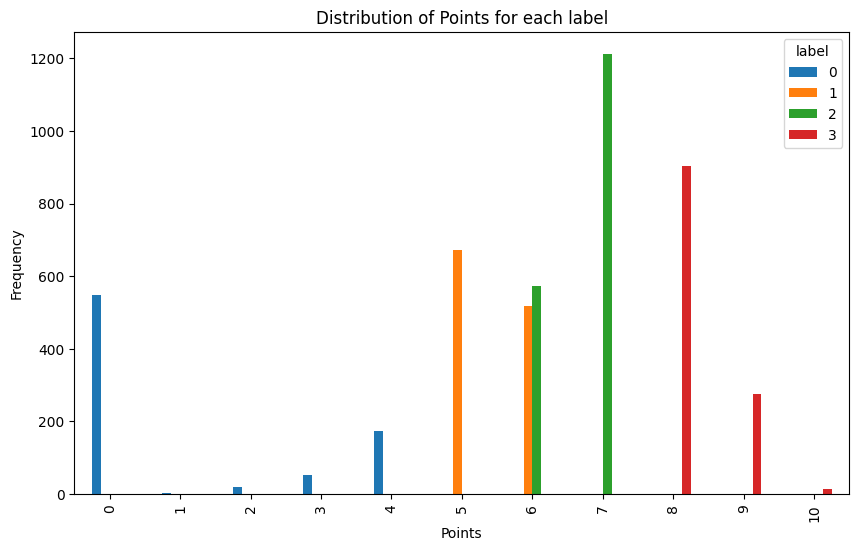

----------------------------------------------------------------------------------------------------


In [ ]:
#Draw data with label column and numeric variables
for col in numeric_columns:
  print(col)
  grouped_data = df.groupby([col, 'label'])[col].count().unstack()

  # Plotting
  ax = grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))

  # Set labels and title
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")
  plt.title(f"Distribution of {col} for each label")
  plt.legend(title='label')

  # Show the plot
  plt.show()
  print('-'*100)

#### b. Object variables

Sex


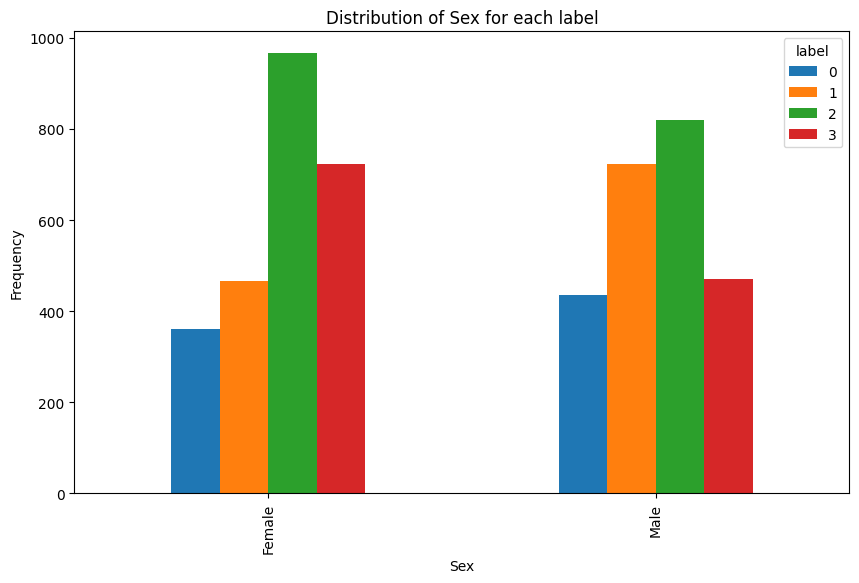

----------------------------------------------------------------------------------------------------
Readbook


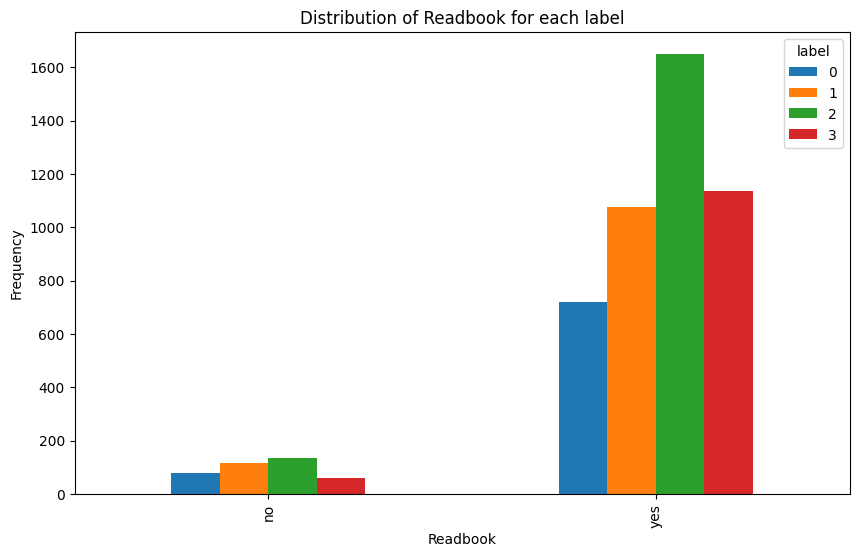

----------------------------------------------------------------------------------------------------
Topic


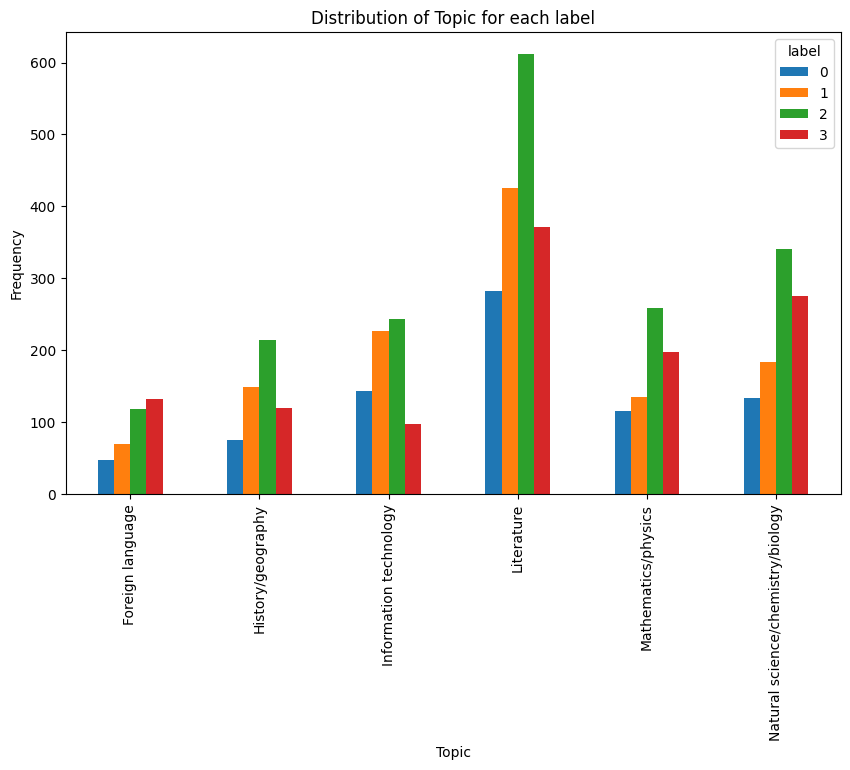

----------------------------------------------------------------------------------------------------
FutureJob


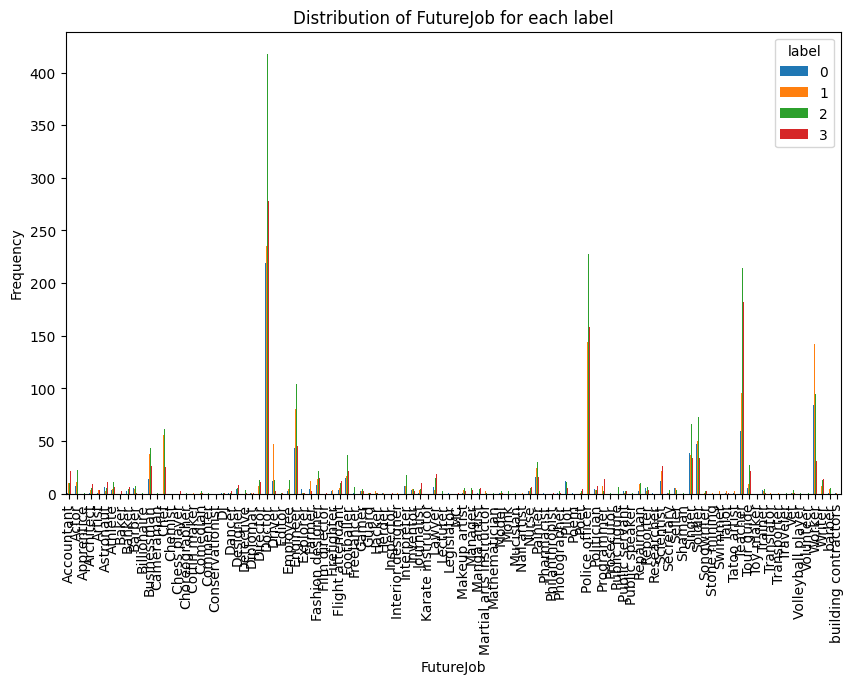

----------------------------------------------------------------------------------------------------
CareerFat


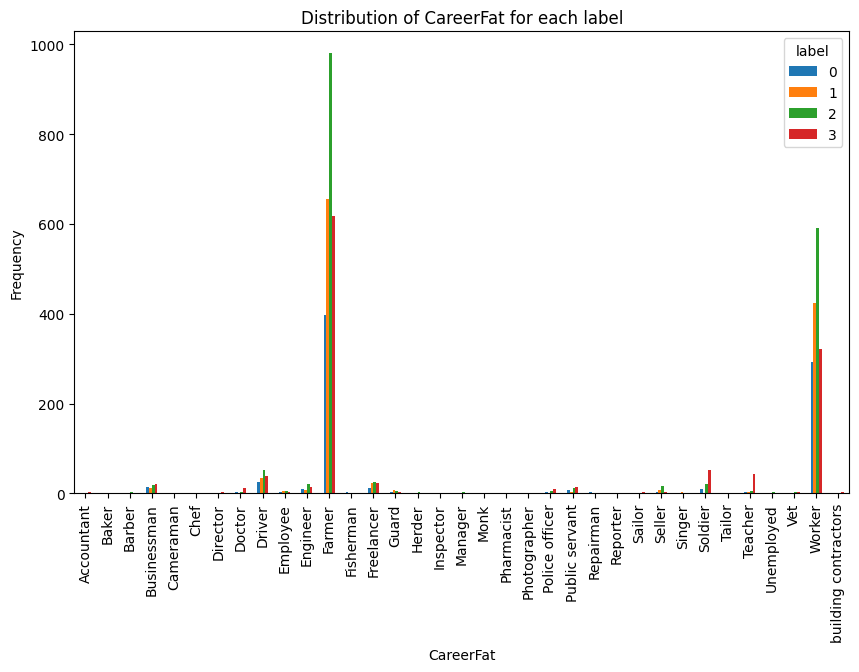

----------------------------------------------------------------------------------------------------
CarFatGr


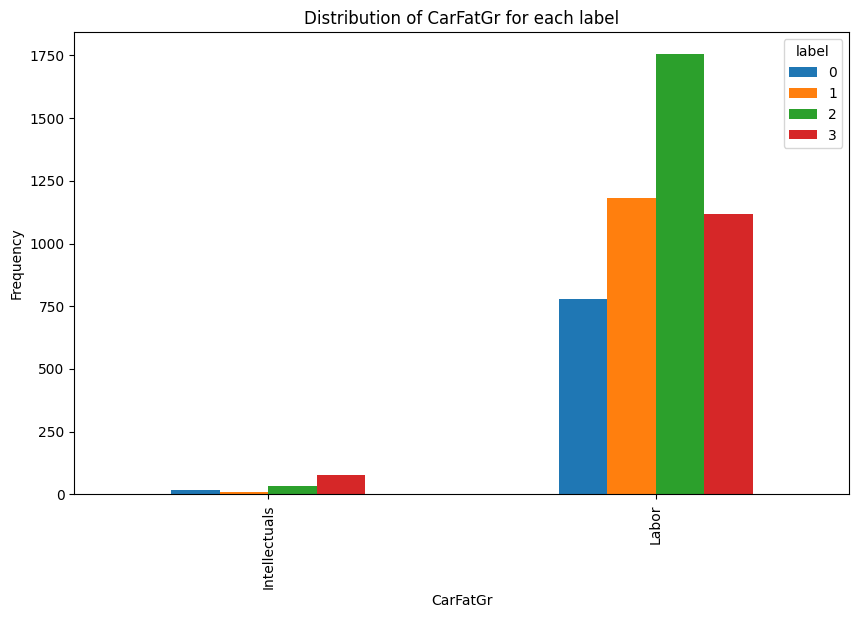

----------------------------------------------------------------------------------------------------
EduFat


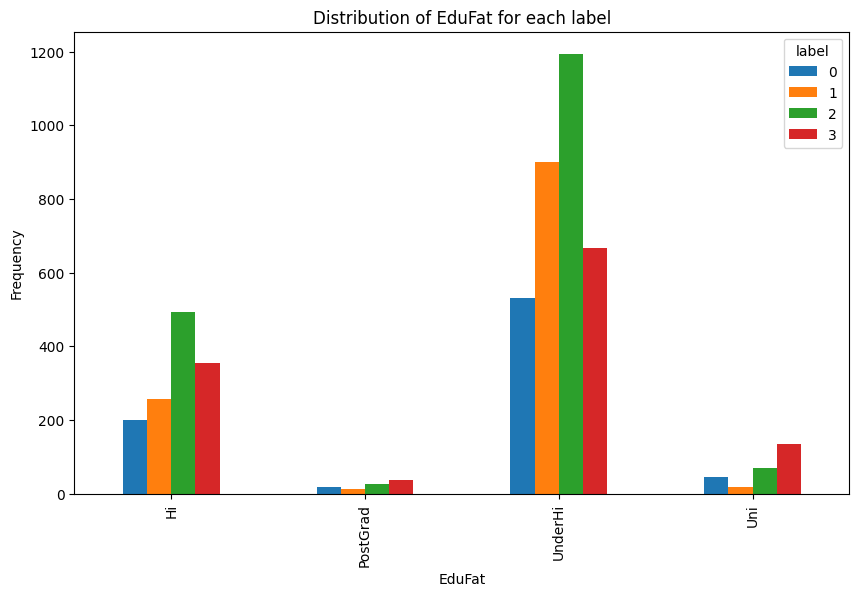

----------------------------------------------------------------------------------------------------
CareerMot


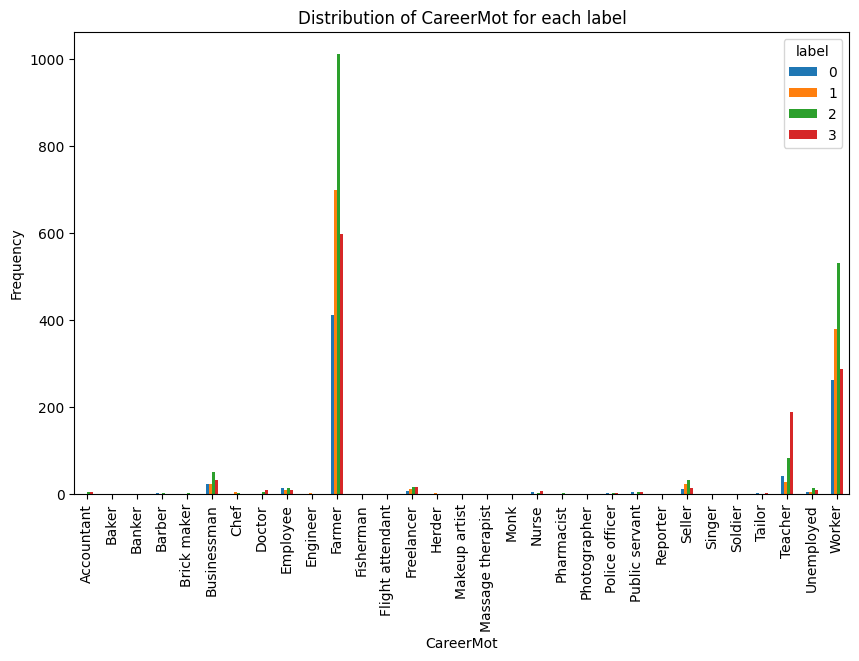

----------------------------------------------------------------------------------------------------
CarMotGr


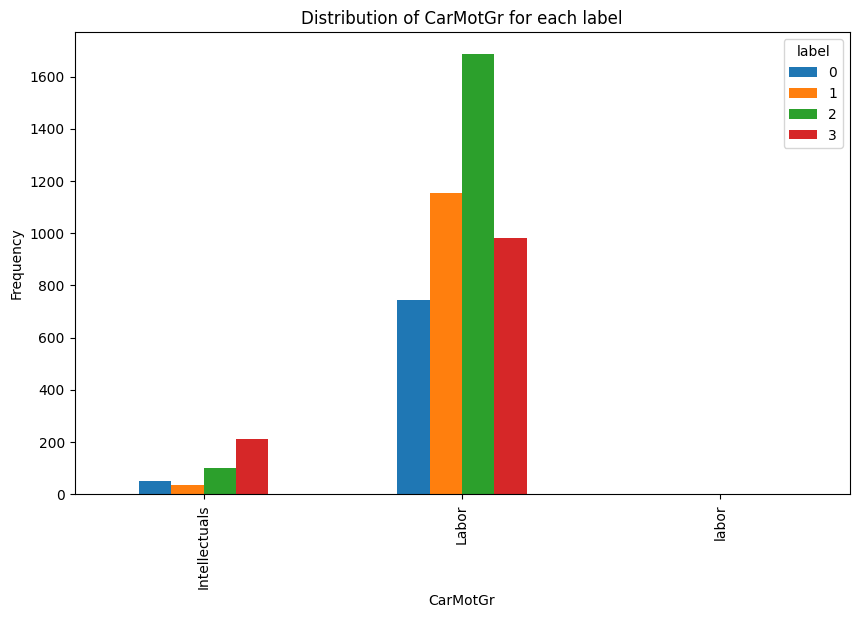

----------------------------------------------------------------------------------------------------
EduMot


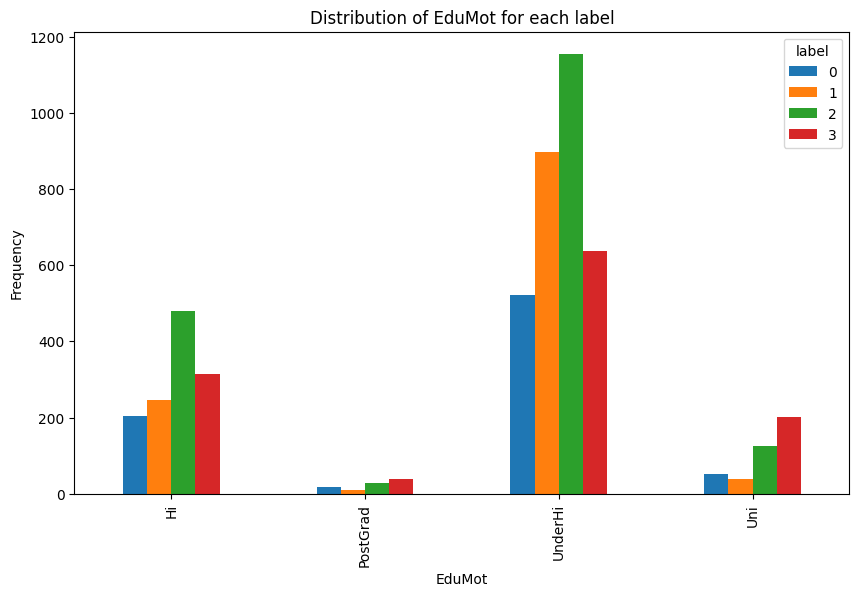

----------------------------------------------------------------------------------------------------
EcoStt


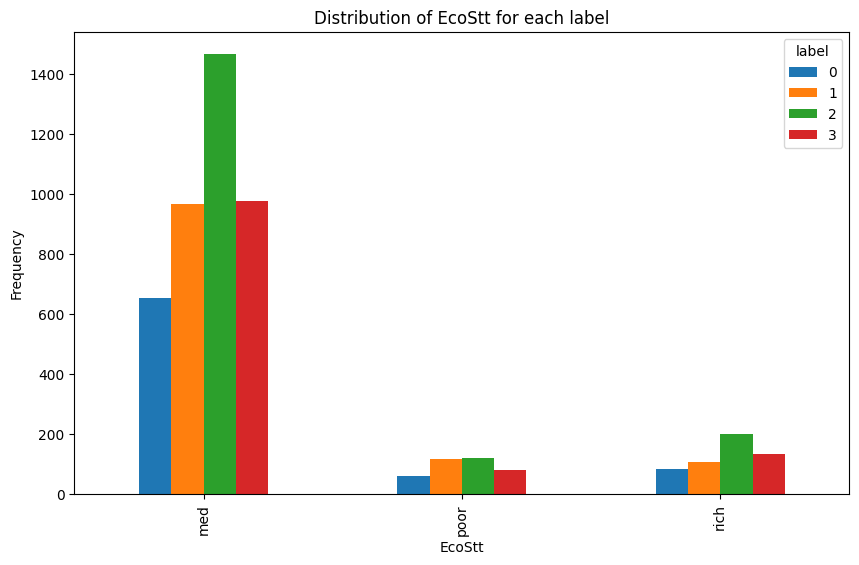

----------------------------------------------------------------------------------------------------
KnowledgeInc


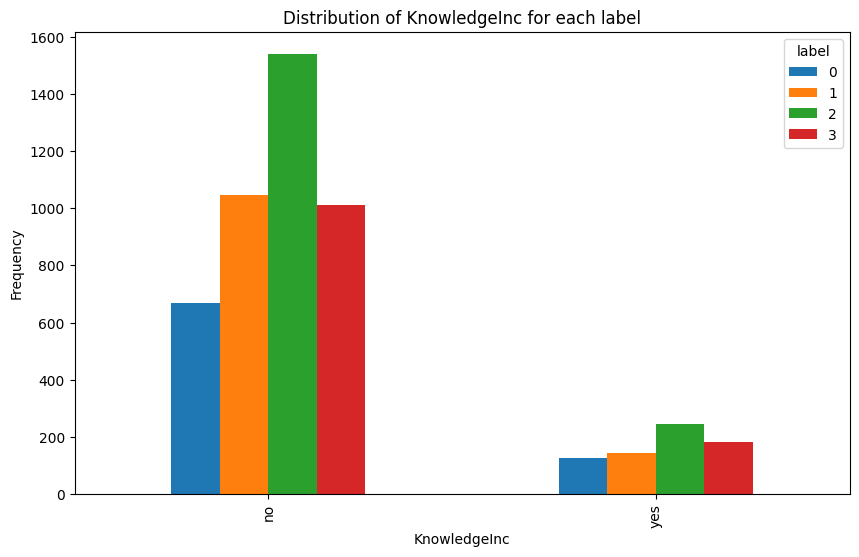

----------------------------------------------------------------------------------------------------
Buybook


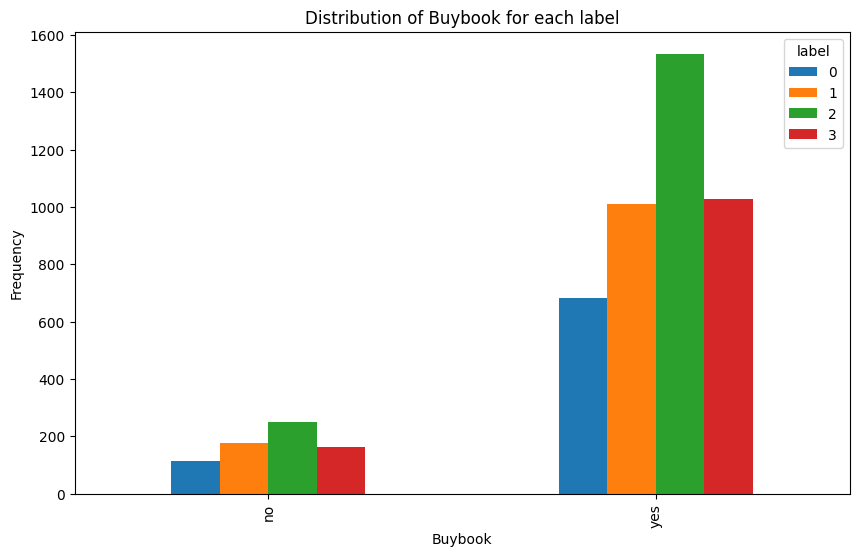

----------------------------------------------------------------------------------------------------
Hobby


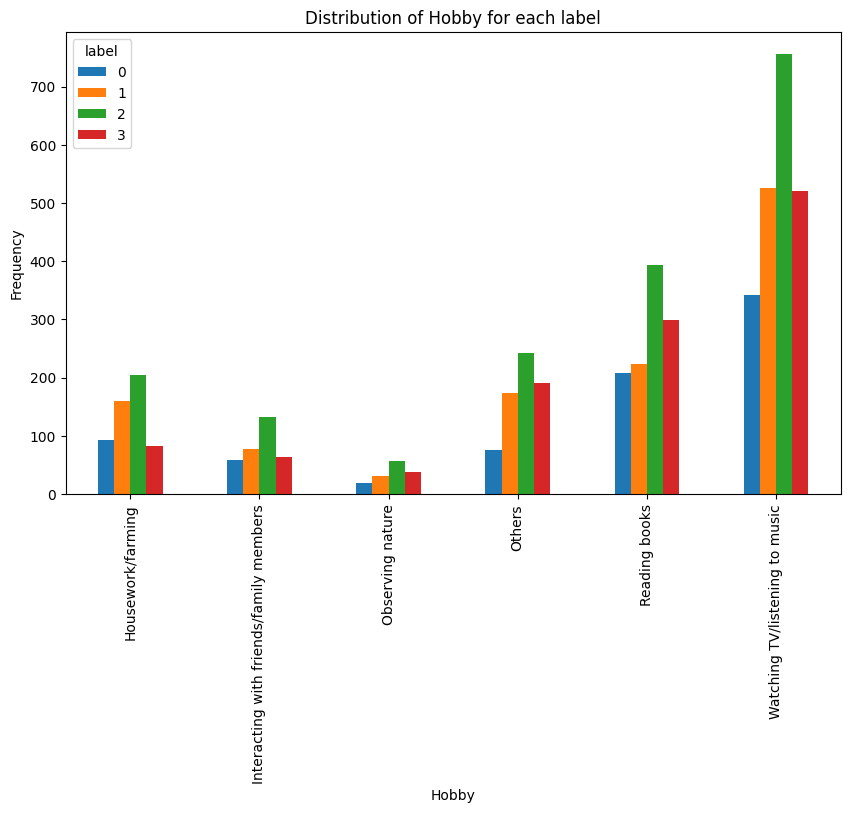

----------------------------------------------------------------------------------------------------
Readstory


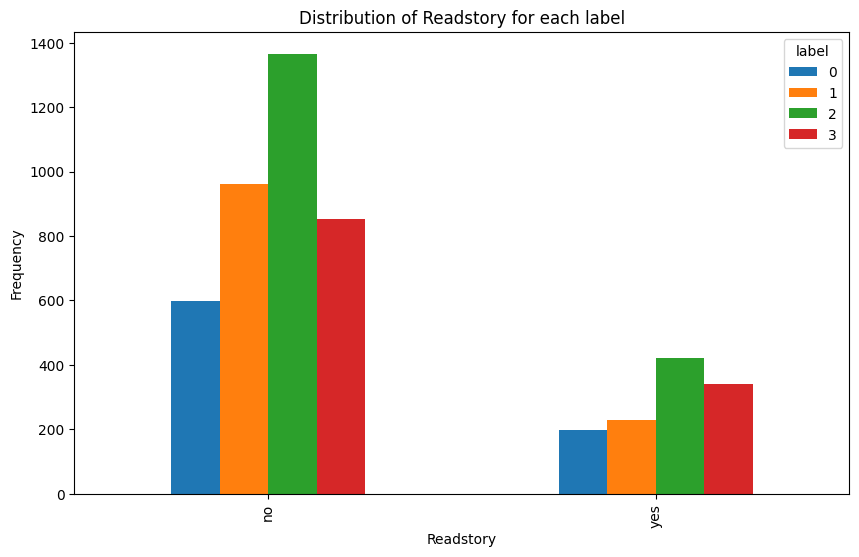

----------------------------------------------------------------------------------------------------
Typebook


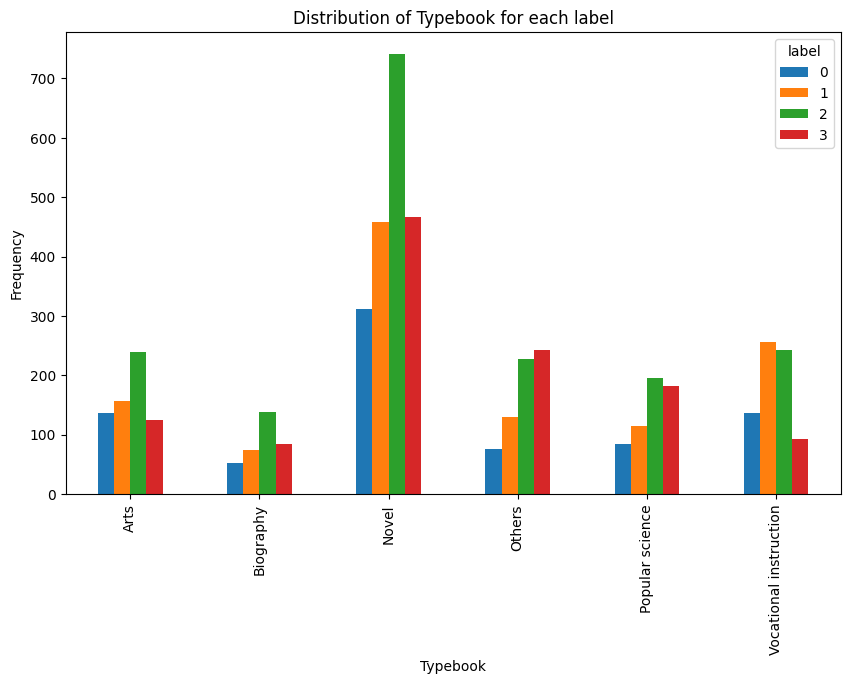

----------------------------------------------------------------------------------------------------
Reason


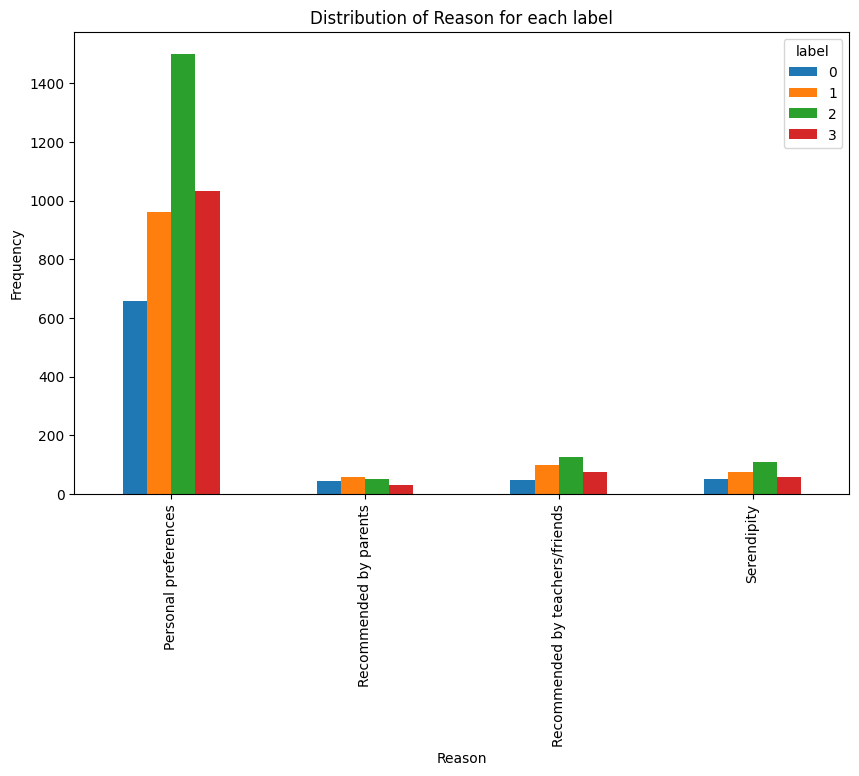

----------------------------------------------------------------------------------------------------
Source


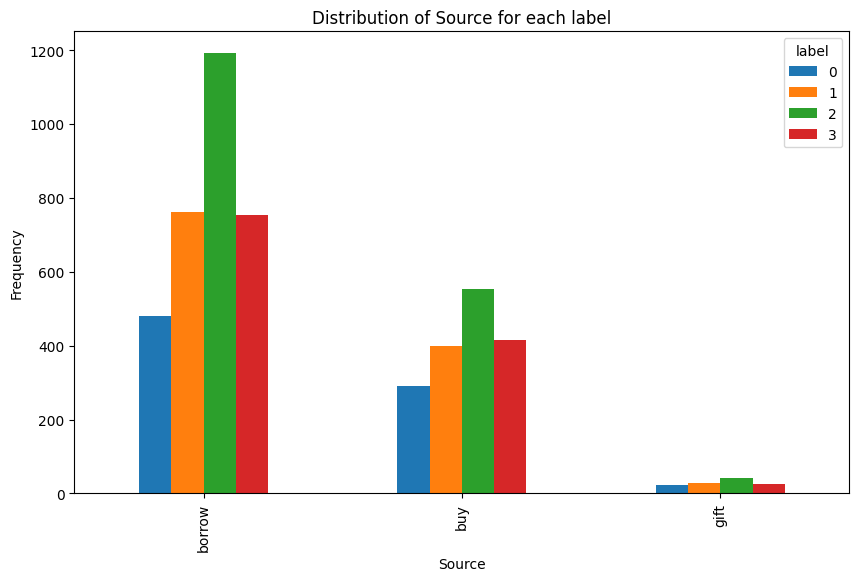

----------------------------------------------------------------------------------------------------
PrioAct


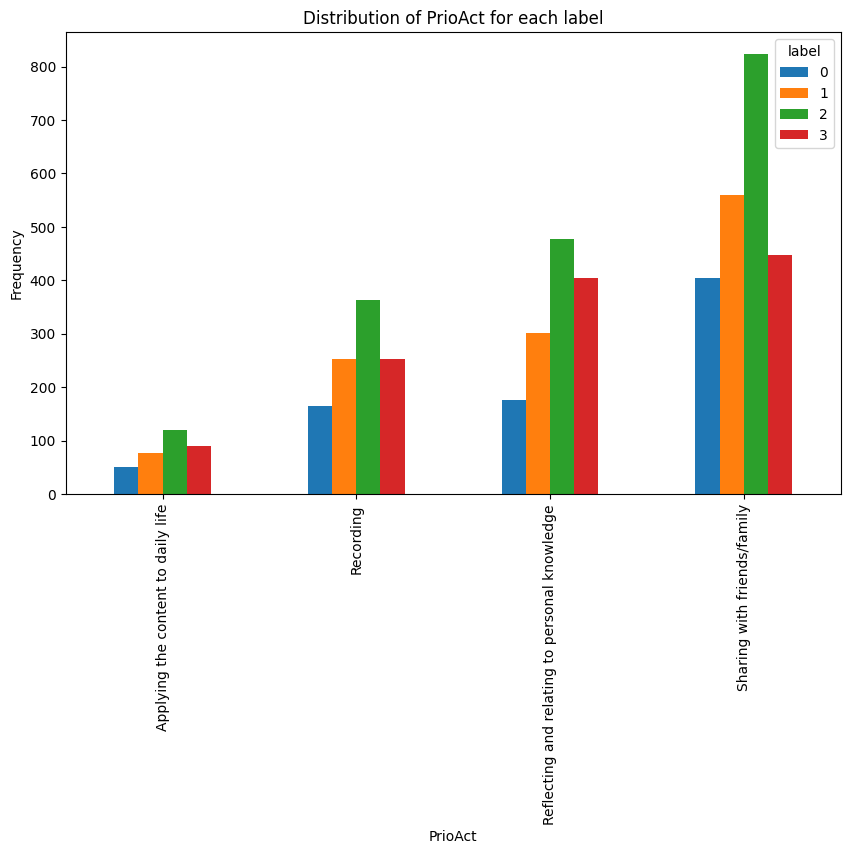

----------------------------------------------------------------------------------------------------
AftAct


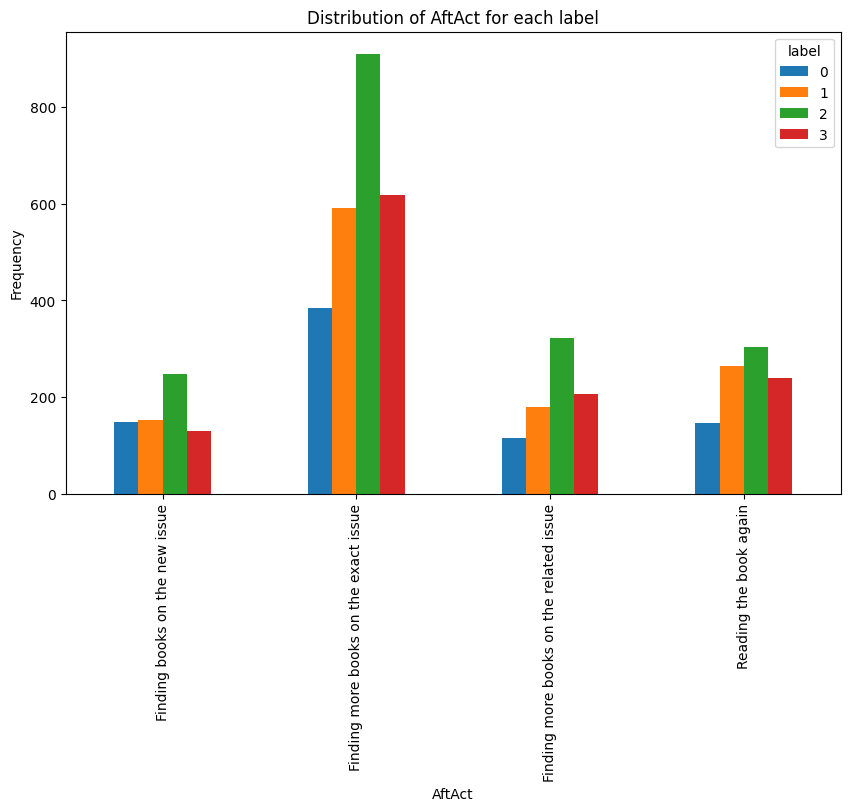

----------------------------------------------------------------------------------------------------
EncourAct


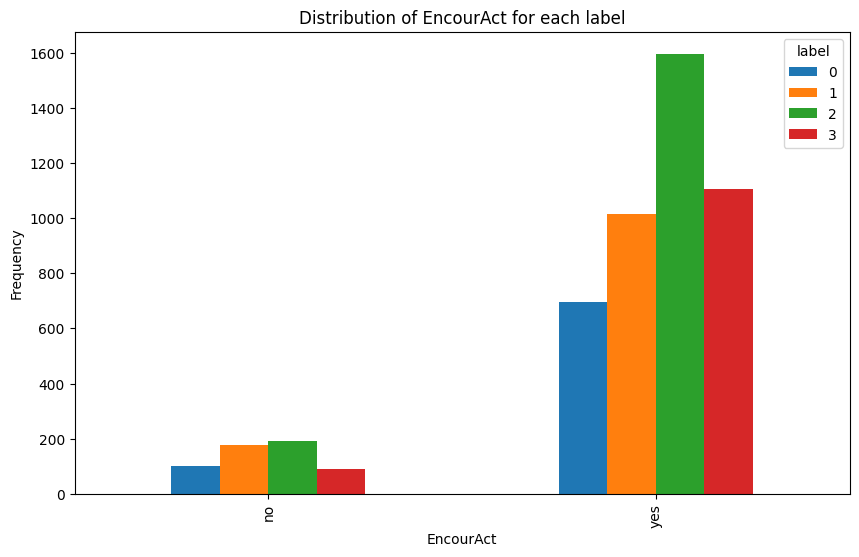

----------------------------------------------------------------------------------------------------
MostlikedAct


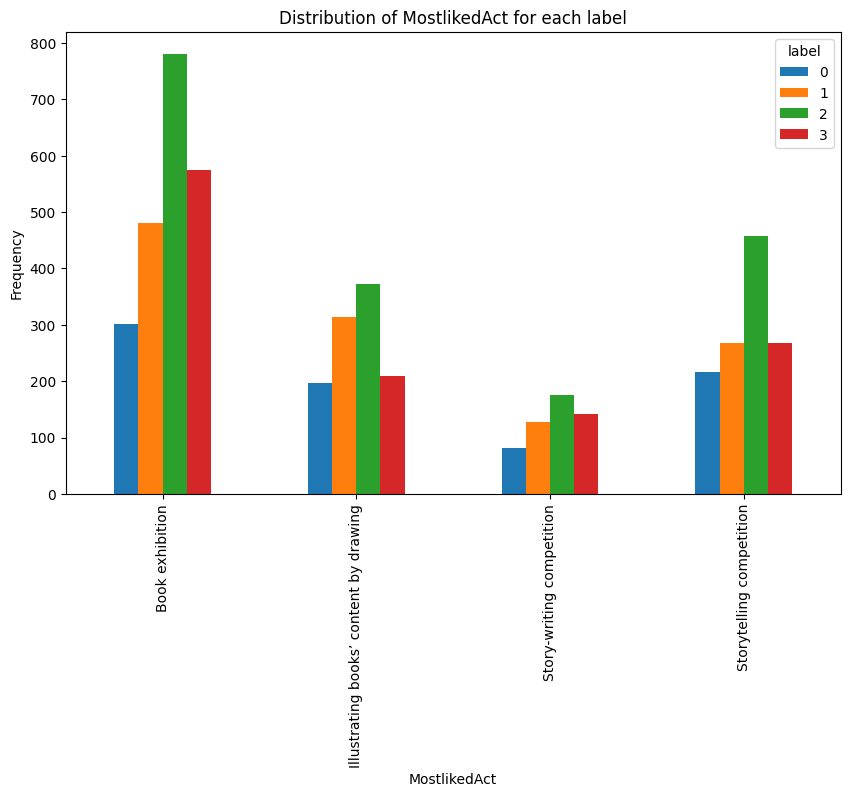

----------------------------------------------------------------------------------------------------
Bookcase


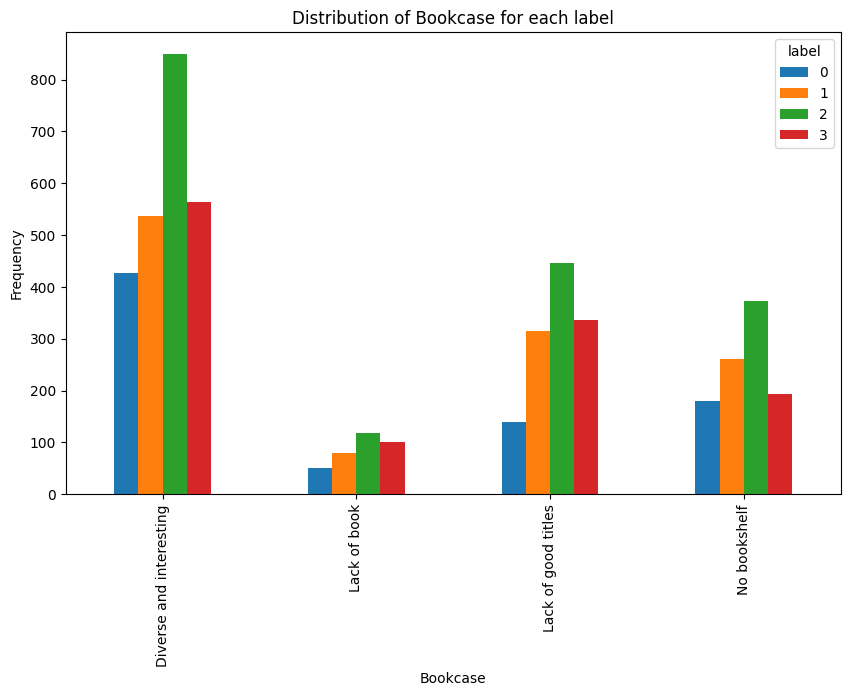

----------------------------------------------------------------------------------------------------


In [ ]:
#Draw data with label column and object variables
for col in object_columns:
  print(col)
  grouped_data = df.groupby([col, 'label'])[col].count().unstack()

  # Plotting
  ax = grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))

  # Set labels and title
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")
  plt.title(f"Distribution of {col} for each label")
  plt.legend(title='label')

  # Show the plot
  plt.show()
  print('-'*100)

All figures above (with label column) illustrate the pattern distribution comparison between the 'label' variable and other predictor variables. When pattern distributions exhibit high similarity, it indicates minimal statistical differentiation between variables, suggesting these predictors have relatively lower contribution weights to the model's predictive capability compared to variables displaying more distinct distributional patterns.

# EDA

## a. Point Distribution

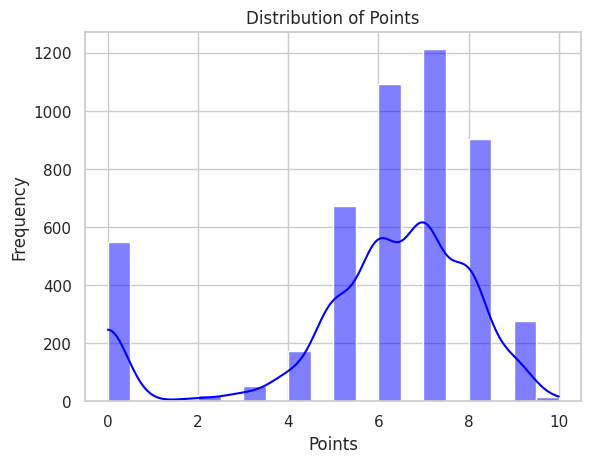

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
sns.histplot(df['Points'], kde=True, bins=20, color='blue')
plt.title(f"Distribution of Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

This graph illustrates points appears to have a slightly left-skewed distribution, exhibiting a distinct concentration in the 6-8 point range, with a secondary cluster at 0 points, indicating a bimodal distribution pattern.

##b. Gender and Label Distribution:
 A count plot showing how labels are distributed across sexes, providing insight into any gender-based differences.

<ipython-input-31-874d622653ce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='muted')


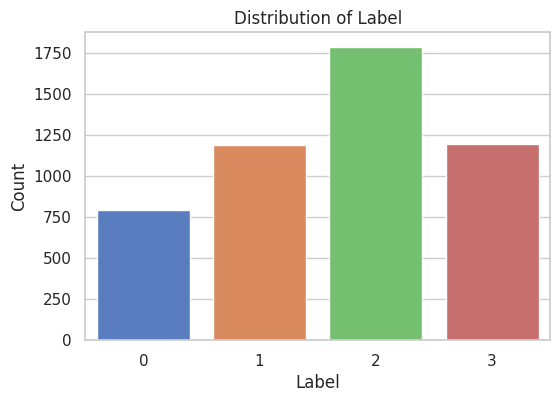

In [ ]:
# Distribution of the target variable `label`
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='muted')
plt.title("Distribution of Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

This graph illustrates the distribution of labels representing student performance in the class. Labels 2 and 3 correspond to higher-performing students, with Label 2 indicating scores above 6.5 and Label 3 denoting scores exceeding 8. The data demonstrates that Label 2 has the highest count, suggesting a larger proportion of students with moderately high performance, while Label 3 represents the group achieving the highest academic excellence.

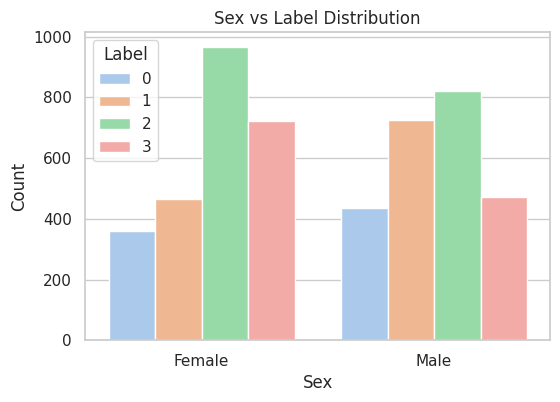

In [ ]:
# Relationship between Sex and label
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='label', data=df, palette='pastel')
plt.title("Sex vs Label Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()

In this graph, both genders exhibit strong performance, with the majority achieving Labels 2 and 3. While females slightly edge out males in Label 3 (highest scores), performance is fairly balanced overall. The distinct patterns observed in the gender-label relationship suggest that gender may serve as a significant predictor variable in modelling student academic performance.

##c. Frequency of values in key categorical features: Hobby, Bookcase and Points

The student’s perception of the classroom’s bookshelf condition

<ipython-input-33-5c8bc3f816c9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)


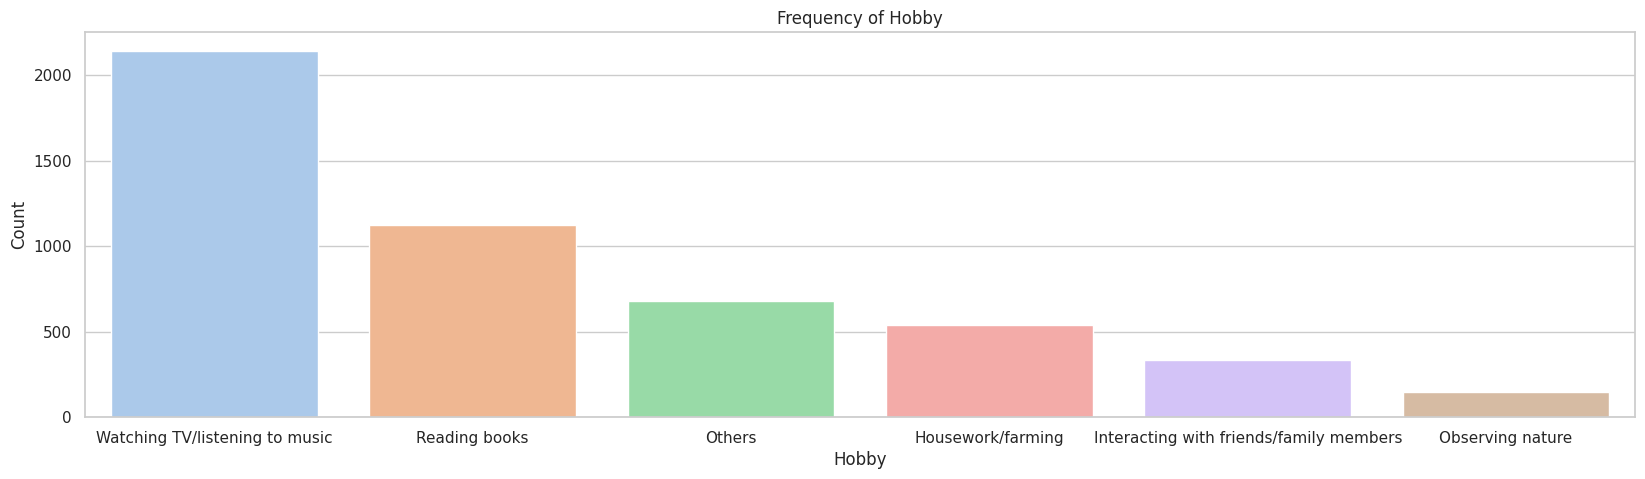

<ipython-input-33-5c8bc3f816c9>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)


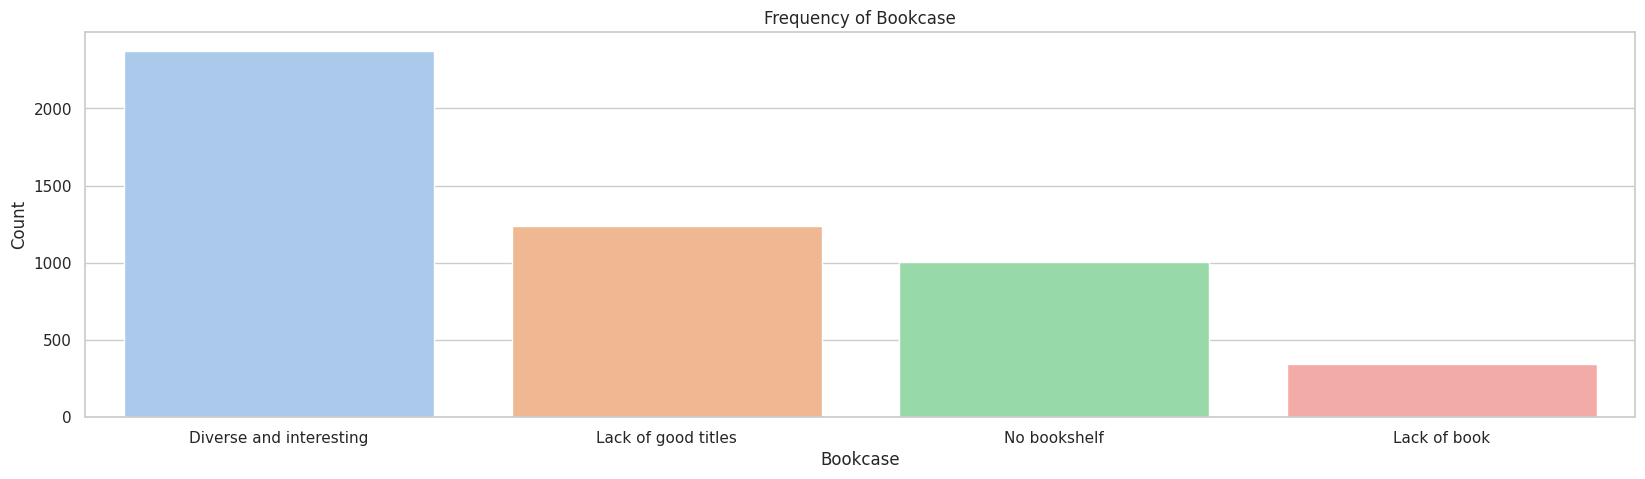

In [ ]:
# Frequency of values in key categorical features
categorical_features = ['Hobby', 'Bookcase']
for feature in categorical_features:
    plt.figure(figsize=(20, 5))
    sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)
    plt.title(f"Frequency of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

In this 2 graphs, students predominantly enjoy watching TV and listening to music but also appreciate the diversity and interesting selection of books available in the classroom's bookcase. However, there is some room for improvement in addressing perceived gaps, such as the lack of specific good titles or the presence of bookshelves in classrooms.

<ipython-input-34-9a4a56d79212>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


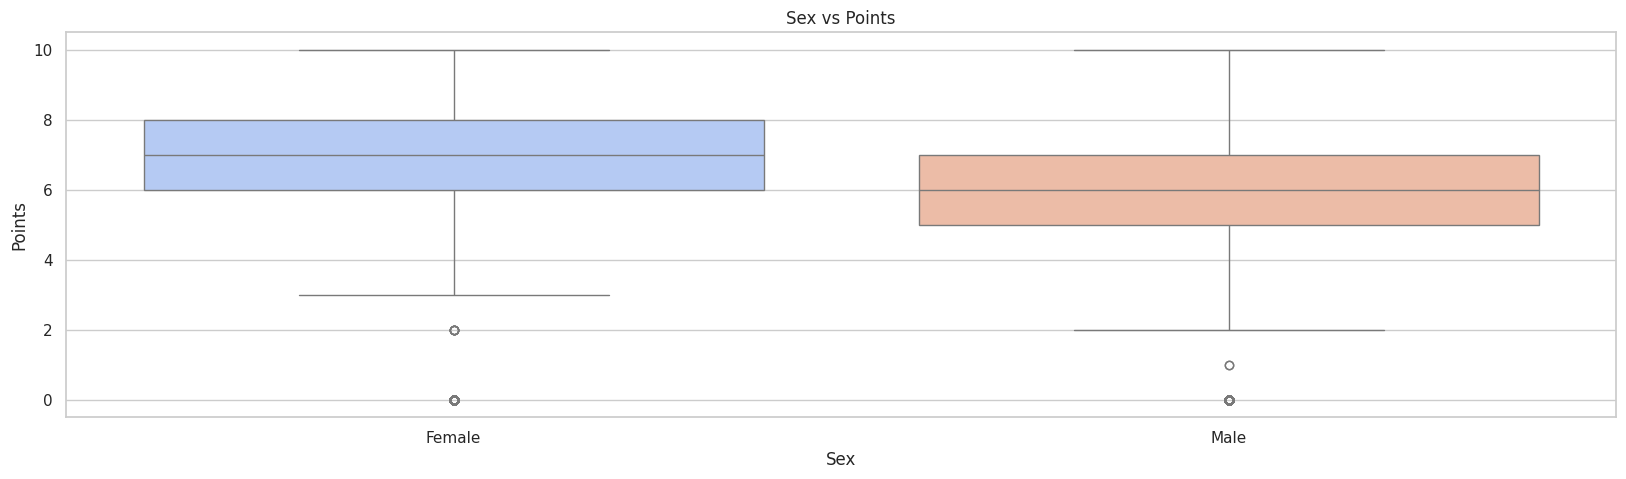

<ipython-input-34-9a4a56d79212>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


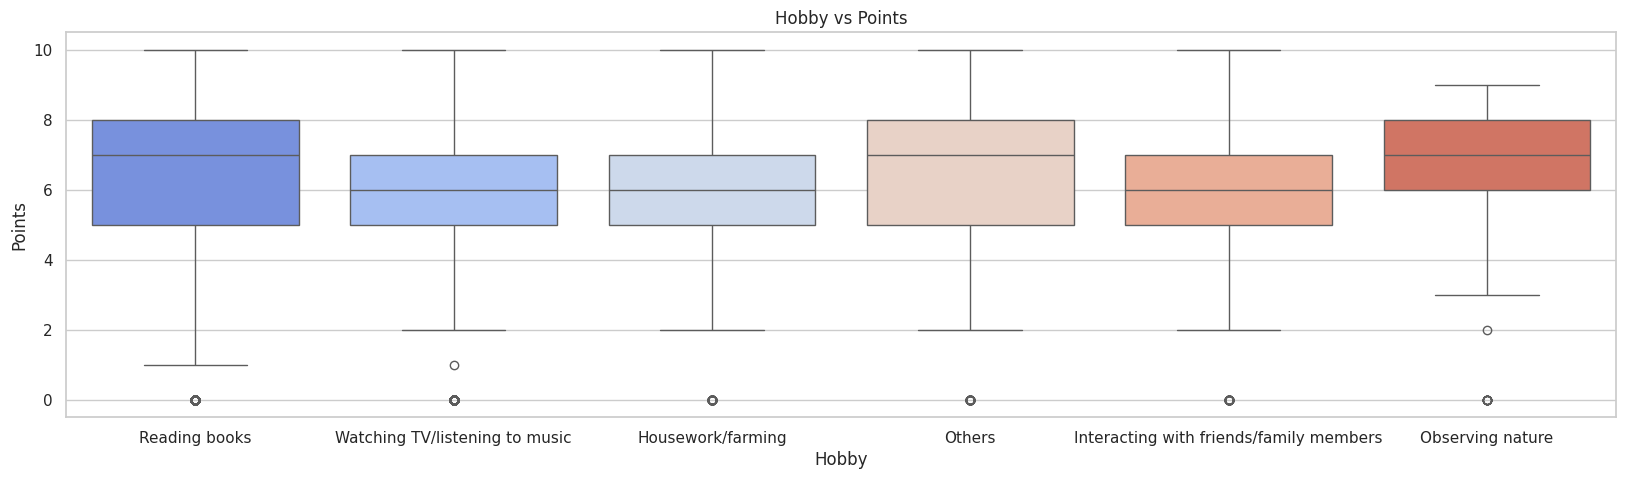

<ipython-input-34-9a4a56d79212>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


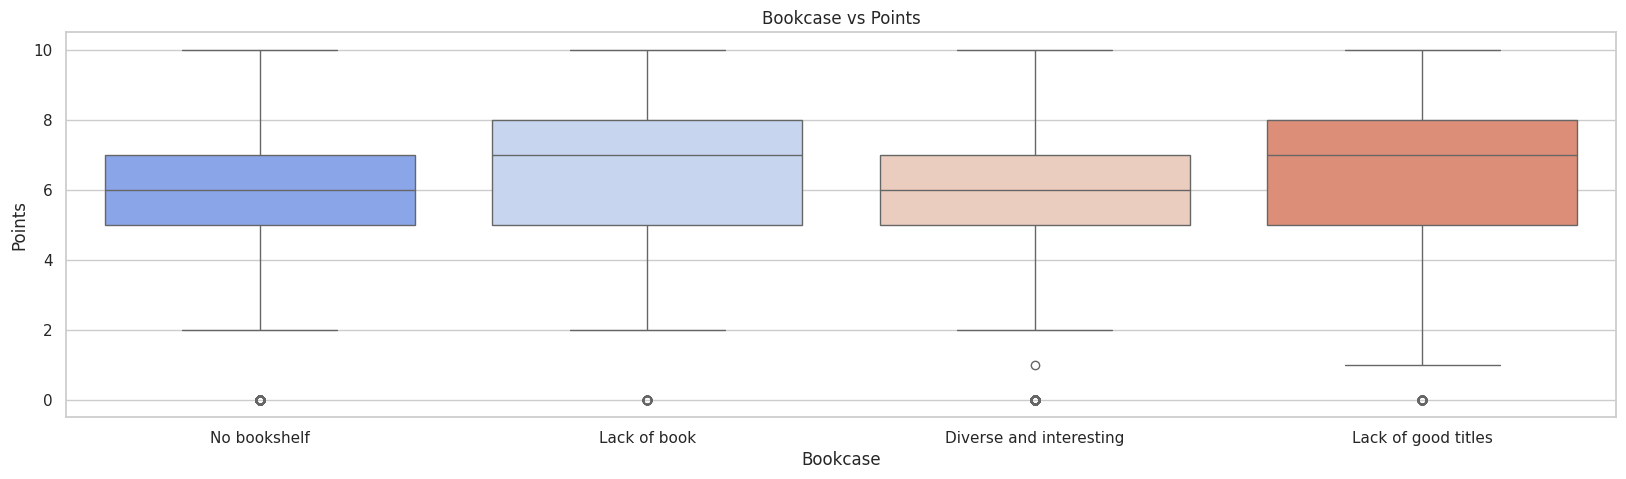

In [ ]:
# Categorical features vs Points
categorical_features_vs_points = ['Sex', 'Hobby', 'Bookcase']
for feature in categorical_features_vs_points:
    plt.figure(figsize=(20,5))
    sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')
    plt.title(f"{feature} vs Points")
    plt.xlabel(feature)
    plt.ylabel("Points")
    plt.show()


The graph of Hobby and Points demonstrates that reading books and nature observation emerge as the predominant recreational activities, exhibiting consistently high point allocations, whereas domestic activities such as housework and farming display lower mean scores with increased variance. The 'Others' category manifests the greatest distributional spread, reflecting diverse hobbies. Social interactions with family and peers demonstrate intermediate point allocations with moderate variability, while the majority of activities exhibit statistical outliers.

In addition, the graph of Bookcase and Points reveals that responses pertaining to 'lack of good titles' and 'diverse and interesting' content achieved the highest median scores, demonstrating strong user preferences. "No bookshelf" and "Lack of book" have slightly lower medians with consistent distributions, suggesting moderate interest. While statistical outliers are present in the dataset, their impact on the overall distributional trends remains negligible.

<ipython-input-35-2af9cd569fd3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


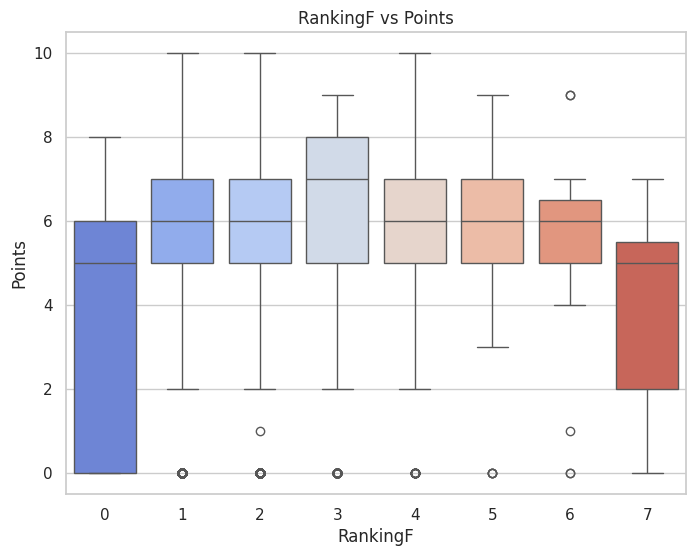

<ipython-input-35-2af9cd569fd3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


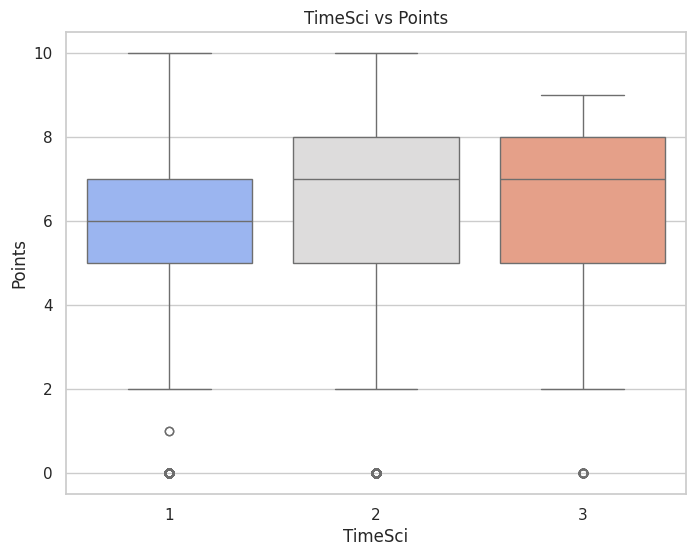

<ipython-input-35-2af9cd569fd3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


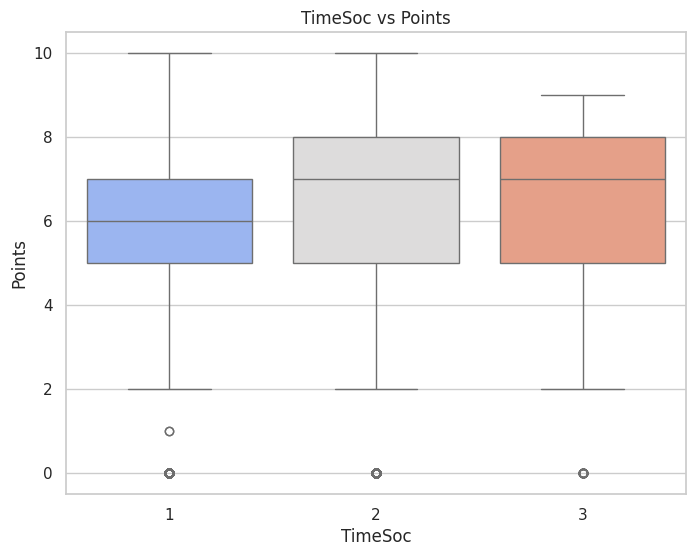

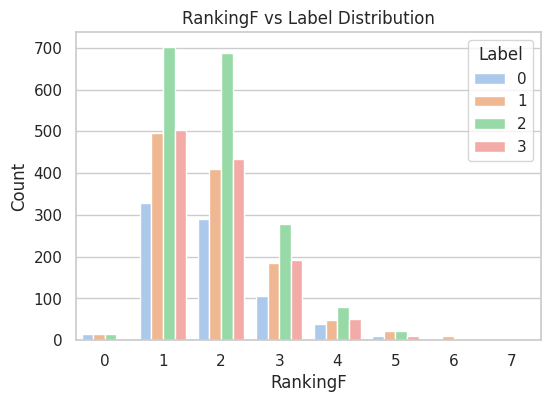

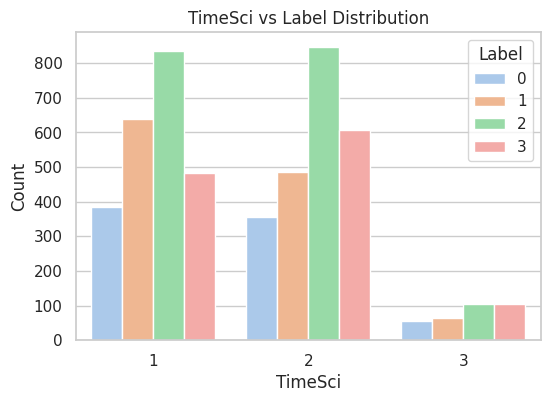

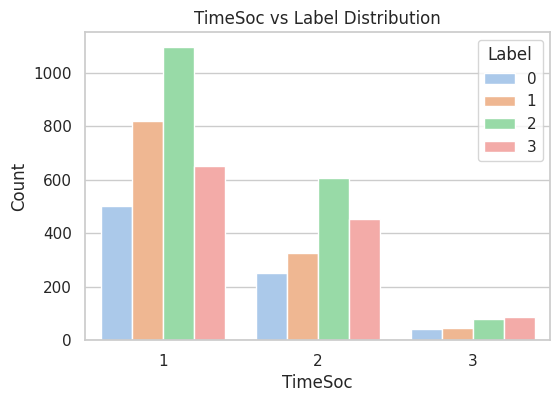

In [ ]:
categorical_columns = ['RankingF', 'TimeSci', 'TimeSoc']

# Categorical Features vs Points
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')
    plt.title(f"{col} vs Points")
    plt.xlabel(col)
    plt.ylabel("Points")
    plt.show()

# Categorical Relationships with Label
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='label', data=df, palette='pastel')
    plt.title(f"{col} vs Label Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Label")
    plt.show()


In graph Ranking family and Label Distribution, first- and second-born children (Ranking 1 and 2) are associated with higher label scores (2 and 3), indicating stronger performance or outcomes. Later-born children (Ranking 3 and beyond) have fewer observations and are more likely to have lower scores (Label 0 or 1), suggesting a possible correlation between birth order and label scores. Families with more than three children are underrepresented in this data.

Additionally, The analysis of the graph Time to learn science and lable indicates that students dedicating 1-2 hours to science education represent the modal distribution and demonstrate enhanced academic outcomes, with Label 2 predominating this cohort. While spending 3 hours may not show a significant increase in higher scores, it does reflect a balanced performance distribution across all labels.

Moreover, with analysis of social studies engagement reveals that the majority of students allocate 1-2 hours to the subject, correlating with higher academic achievement (Labels 2 and 3). While three-hour study periods are statistically infrequent, they demonstrate homogeneous performance distribution across all labels, suggesting that extended study duration beyond two hours yields minimal additional academic benefits.

## d. Analysis of Future Jobs: Grouping Future Job

**Define categories like:**
STEM: Science, Technology, Engineering, Mathematics-related roles.

Health: Medical and healthcare-related roles.

Education: Teaching and academic roles.

Business: Business, management, and finance-related roles.

Arts: Creative and performing arts-related roles.

Other: Miscellaneous or undefined roles.

Create a new column, FutureJobGroup, based on the mapping.

<ipython-input-36-7821dc6b820f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_job_group_counts.index, y=future_job_group_counts.values, palette='tab10')


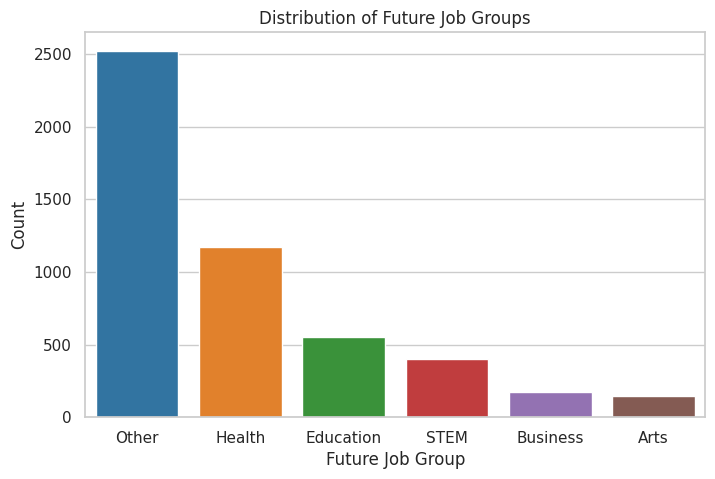

In [ ]:
# Define a mapping for FutureJob categories
def group_future_job(job):
    if any(word in job.lower() for word in ['engineer', 'scientist', 'developer', 'programmer']):
        return 'STEM'
    elif any(word in job.lower() for word in ['doctor', 'nurse', 'dentist', 'pharmacist']):
        return 'Health'
    elif any(word in job.lower() for word in ['teacher', 'professor', 'educator']):
        return 'Education'
    elif any(word in job.lower() for word in ['business', 'manager', 'accountant', 'finance']):
        return 'Business'
    elif any(word in job.lower() for word in ['artist', 'writer', 'actor', 'musician']):
        return 'Arts'
    else:
        return 'Other'

# Create a new column for grouped future job categories
df['FutureJobGroup'] = df['FutureJob'].apply(group_future_job)

# Check the distribution of the new grouping
future_job_group_counts = df['FutureJobGroup'].value_counts()

# Visualize the distribution of FutureJobGroup
plt.figure(figsize=(8, 5))
sns.barplot(x=future_job_group_counts.index, y=future_job_group_counts.values, palette='tab10')
plt.title("Distribution of Future Job Groups")
plt.xlabel("Future Job Group")
plt.ylabel("Count")
plt.show()


The data above highlights the diversity in students' future career aspirations, with a strong inclination toward health-related professions and significant interest in diverse, non-traditional roles captured under the "Other" category. This suggests a need to further explore and understand the specific career choices within the "Other" group.

<ipython-input-37-19b7a4839a87>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='FutureJobGroup', x='Points', data=df, palette='Set3')


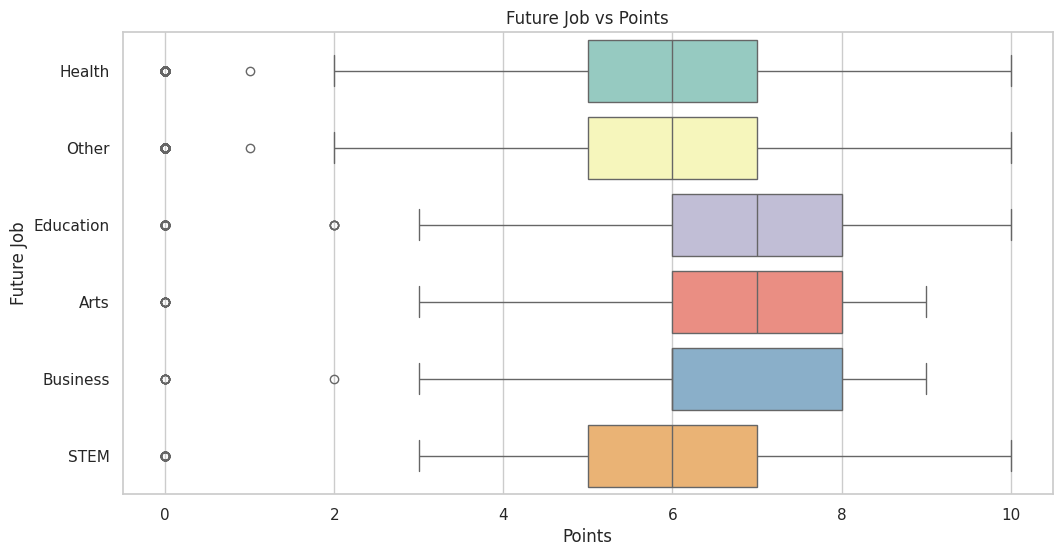

In [ ]:
# FutureJob vs Points
plt.figure(figsize=(12, 6))
sns.boxplot(y='FutureJobGroup', x='Points', data=df, palette='Set3')
plt.title("Future Job vs Points")
plt.xlabel("Points")
plt.ylabel("Future Job")
plt.show()

<Figure size 1200x600 with 0 Axes>

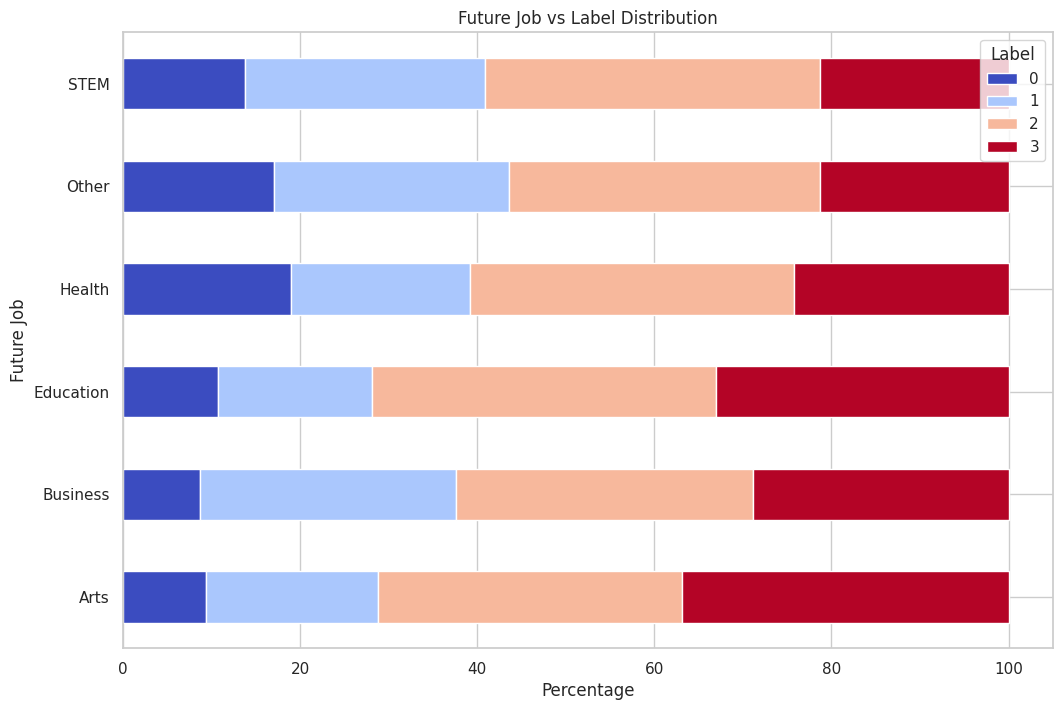

In [ ]:
# FutureJob vs Label Distribution
plt.figure(figsize=(12, 6))
future_job_label = pd.crosstab(df['FutureJobGroup'], df['label'], normalize='index') * 100
future_job_label.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='coolwarm')
plt.title("Future Job vs Label Distribution")
plt.xlabel("Percentage")
plt.ylabel("Future Job")
plt.legend(title="Label")
plt.show()

In this graph, students aspiring for careers in STEM, Health, and Education generally demonstrate higher academic performance, with a significant proportion achieving Label 3. In contrast, students aiming for Arts and Business careers tend to have lower performance, with a larger share in Labels 0 and 1. This distribution indicates a correlation between career aspirations and academic performance levels, with technical and health-related fields attracting stronger performers.

# Build ML Models

## Variable transformation

In [ ]:
df.head(5)

,School,Grade,Sex,RankingF,NumberofChi,Readbook,Topic,FutureJob,CareerFat,CarFatGr,AgeFat,EduFat,CareerMot,CarMotGr,AgeMot,EduMot,EcoStt,KnowledgeInc,Buybook,Hobby,TimeSci,TimeSoc,Readstory,Typebook,Reason,Source,PrioAct,AftAct,EncourAct,MostlikedAct,Bookcase,Points,label,FutureJobGroup
0,2,8,Female,3,4,yes,History/geography,Doctor,Farmer,Labor,48,UnderHi,Worker,Labor,40,UnderHi,med,no,yes,Reading books,2,2,no,Popular science,Personal preferences,buy,Sharing with friends/family,Finding more books on the related issue,yes,Storytelling competition,No bookshelf,7,2,Health
1,3,9,Female,0,0,yes,Natural science/chemistry/biology,Painter,Police officer,Labor,45,Uni,Teacher,Intellectuals,35,Uni,rich,no,yes,Watching TV/listening to music,2,1,yes,Arts,Personal preferences,buy,Applying the content to daily life,Finding more books on the exact issue,yes,Illustrating books’ content by drawing,Lack of book,0,0,Other
2,3,9,Female,1,2,yes,Literature,Worker,Farmer,Labor,45,Hi,Farmer,Labor,35,Hi,med,no,yes,Housework/farming,2,1,no,Novel,Personal preferences,buy,Sharing with friends/family,Finding more books on the exact issue,yes,Storytelling competition,Diverse and interesting,6,2,Other
3,3,9,Female,1,2,yes,Natural science/chemistry/biology,Public servant,Worker,Labor,41,Hi,Worker,Labor,40,Hi,med,no,yes,Watching TV/listening to music,1,1,no,Popular science,Personal preferences,buy,Reflecting and relating to personal knowledge,Finding more books on the exact issue,yes,Book exhibition,No bookshelf,8,3,Other
4,3,9,Female,2,3,yes,Natural science/chemistry/biology,Athlete,Farmer,Labor,38,UnderHi,Farmer,Labor,36,UnderHi,med,no,yes,Watching TV/listening to music,1,1,no,Novel,Personal preferences,borrow,Sharing with friends/family,Finding more books on the related issue,yes,Illustrating books’ content by drawing,No bookshelf,9,3,Other


In [ ]:
# Define a function to map a job to a category
def map_future_job(job):
    # Check if the job exists in the 'CareerFat' column
    if len(df[df['CareerFat'] == job]) > 0:
        # If it exists, return the corresponding value from the 'CarFatGr' column
        return df[df['CareerFat'] == job]['CarFatGr'].values[0]

    # Check if the job exists in the 'CareerMot' column
    if len(df[df['CareerMot'] == job]) > 0:
        # If it exists, return the corresponding value from the 'CarMotGr' column
        return df[df['CareerMot'] == job]['CarMotGr'].values[0]

    # If the job is not found in either column, return 'other'
    return 'other'

# Apply the 'map_future_job' function to each value in the 'FutureJob' column
# The resulting mapped category is stored in a new column 'JobCat'
df['JobCat'] = df['FutureJob'].apply(map_future_job)


In [ ]:
# drop 2 columns:  Estimated Income and Typebook_Other
df.drop(['FutureJob', 'CareerFat', 'CareerMot', 'Points'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode all categorical columns in the DataFrame
df = df.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)

# Print the first 10 rows after encoding
print(df.head(10))

   School  Grade  Sex  RankingF  NumberofChi  Readbook  Topic  CarFatGr  \
0       2      8    0         3            4         1      1         1   
1       3      9    0         0            0         1      5         1   
2       3      9    0         1            2         1      3         1   
3       3      9    0         1            2         1      5         1   
4       3      9    0         2            3         1      5         1   
5       3      9    1         1            2         1      1         1   
6       3      9    0         2            2         1      5         1   
7       3      9    0         1            2         1      3         1   
8       3      9    0         4            4         1      3         1   
9       2      8    0         1            2         1      5         1   

   AgeFat  EduFat  CarMotGr  AgeMot  EduMot  EcoStt  KnowledgeInc  Buybook  \
0      48       2         1      40       2       0             0        1   
1      45       3 

In this phase, normalisation of categorical data types was performed to convert them into corresponding numerical formats. Categorical variables are transformed through two distinct encoding methods: label encoding for ordinal data (such as grade levels and education status) and one-hot encoding for nominal variables (like hobbies and book preferences). These steps ensured that all categorical data was appropriately transformed for use in machine learning algorithms.

Checking data before putting in the ML models

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   School          4966 non-null   int64
 1   Grade           4966 non-null   int64
 2   Sex             4966 non-null   int64
 3   RankingF        4966 non-null   int64
 4   NumberofChi     4966 non-null   int64
 5   Readbook        4966 non-null   int64
 6   Topic           4966 non-null   int64
 7   CarFatGr        4966 non-null   int64
 8   AgeFat          4966 non-null   int64
 9   EduFat          4966 non-null   int64
 10  CarMotGr        4966 non-null   int64
 11  AgeMot          4966 non-null   int64
 12  EduMot          4966 non-null   int64
 13  EcoStt          4966 non-null   int64
 14  KnowledgeInc    4966 non-null   int64
 15  Buybook         4966 non-null   int64
 16  Hobby           4966 non-null   int64
 17  TimeSci         4966 non-null   int64
 18  TimeSoc         4966 non-nul

## Training model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


The dataset is partitioned using an 80:20 train-test split ratio with a random state 42, ensuring sufficient data for model training while maintaining a representative test set for evaluation.

In [ ]:
# Split the independent variables (X) and the dependent variable (y) (Use the 'label' column instead of 'Points')
X = df.drop(columns=['label'])  # Independent variables
y = df['label']  # Dependent variable

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
# Scale data
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# Transform on X_test
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
print("XGBoost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("plt version:", matplotlib.__version__)
print("re version:", re.__version__)

XGBoost version: 2.1.3
scikit-learn version: 1.3.1
joblib version: 1.4.2
pandas version: 2.2.2
numpy version: 1.26.4
seaborn version: 0.13.2
plt version: 3.10.0
re version: 2.2.1


In [ ]:
# Define the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
lgbm_classifier = LGBMClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()

# Define parameter grids for GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multi:softprob'],  # Multiclass classification with probabilities
    'eval_metric': ['mlogloss']
}

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multiclass'],
    'num_class': [4],
    'metric': ['multi_logloss'],
}

knn_param_grid = {
    'n_neighbors': [4, 6, 8],
    'weights': ['uniform', 'distance']
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with each classifier
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=skf, scoring='f1_micro')
rf_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=skf, scoring='f1_micro')
xgb_grid_search.fit(X_train, y_train)

lgbm_grid_search = GridSearchCV(lgbm_classifier, lgbm_param_grid, cv=skf, scoring='f1_micro')
lgbm_grid_search.fit(X_train, y_train)

knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=skf, scoring='f1_micro')
knn_grid_search.fit(X_train, y_train)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 6, 8],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

The evaluation process involved systematic hyperparameter tuning using grid search optimization, a well-established technique for identifying optimal model configurations. This approach allowed for a robust comparison across different classifiers while ensuring each model achieved its optimal performance potential.

In [ ]:
# Print best parameters and best scores for each classifier
print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Score:", rf_grid_search.best_score_)

print("XGBoost - Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost - Best Score:", xgb_grid_search.best_score_)

print("LightGBM - Best Parameters:", lgbm_grid_search.best_params_)
print("LightGBM - Best Score:", lgbm_grid_search.best_score_)

print("KNN - Best Parameters:", knn_grid_search.best_params_)
print("KNN - Best Score:", knn_grid_search.best_score_)

Random Forest - Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Random Forest - Best Score: 0.4040793371671182
XGBoost - Best Parameters: {'eval_metric': 'mlogloss', 'max_depth': 8, 'n_estimators': 300, 'objective': 'multi:softprob'}
XGBoost - Best Score: 0.4088611124312849
LightGBM - Best Parameters: {'max_depth': 8, 'metric': 'multi_logloss', 'n_estimators': 500, 'num_class': 4, 'objective': 'multiclass'}
LightGBM - Best Score: 0.40785704101516085
KNN - Best Parameters: {'n_neighbors': 8, 'weights': 'distance'}
KNN - Best Score: 0.332830505520967


## Evaluation

The comparative analysis of machine learning models was conducted using a comprehensive evaluation framework encompassing five distinct performance metrics: the confusion matrix, F1-score, accuracy, precision, and recall.

In [ ]:
# Get predictions on the test data
rf_pred = rf_grid_search.predict(X_test)
xgb_pred = xgb_grid_search.predict(X_test)
lgbm_pred = lgbm_grid_search.predict(X_test)
knn_pred = knn_grid_search.predict(X_test)

In [ ]:
# save models
joblib.dump(rf_grid_search, "rf_model.pkl")
joblib.dump(xgb_grid_search, "xgb_model.pkl")
joblib.dump(lgbm_grid_search, "lgbm_model.pkl")
joblib.dump(knn_grid_search, "knn_model.pkl")

['knn_model.pkl']

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.03      0.05       151
           1       0.54      0.25      0.34       259
           2       0.40      0.86      0.54       350
           3       0.52      0.23      0.32       234

    accuracy                           0.43       994
   macro avg       0.47      0.34      0.31       994
weighted avg       0.47      0.43      0.36       994



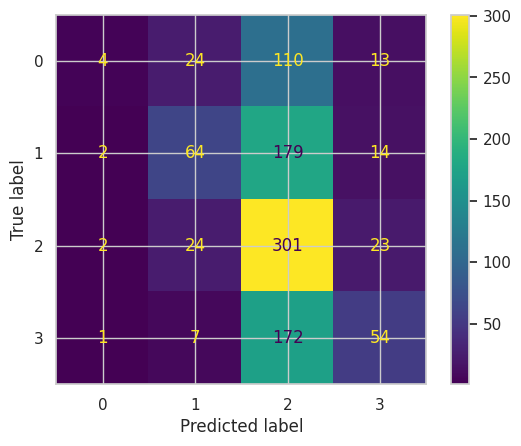

In [ ]:
# Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred, labels=rf_grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_grid_search.classes_)
disp.plot()

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.25      0.26       151
           1       0.42      0.34      0.38       259
           2       0.42      0.55      0.47       350
           3       0.47      0.39      0.43       234

    accuracy                           0.41       994
   macro avg       0.40      0.38      0.39       994
weighted avg       0.41      0.41      0.41       994



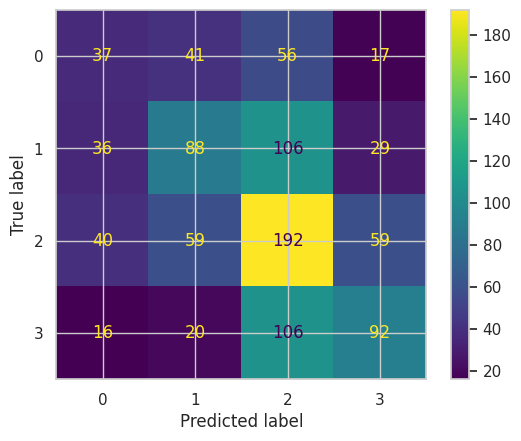

In [ ]:
# XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.23      0.27       151
           1       0.43      0.36      0.39       259
           2       0.42      0.56      0.48       350
           3       0.47      0.40      0.44       234

    accuracy                           0.42       994
   macro avg       0.41      0.39      0.39       994
weighted avg       0.42      0.42      0.41       994



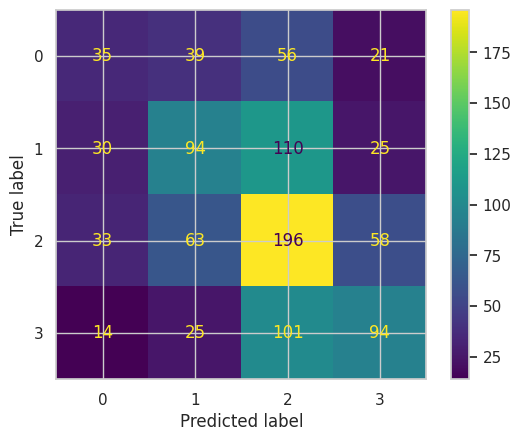

In [ ]:
# LightGBM
print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lgbm_pred)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.16      0.19       151
           1       0.37      0.31      0.34       259
           2       0.39      0.56      0.46       350
           3       0.41      0.31      0.35       234

    accuracy                           0.37       994
   macro avg       0.35      0.33      0.33       994
weighted avg       0.37      0.37      0.36       994



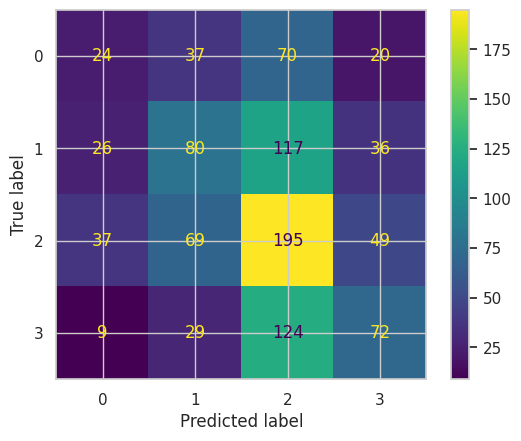

In [ ]:
# KNN
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

# Feature Importances

In [ ]:
# Feature importances in LightGBM model
# Get feature importances
feature_importances = lgbm_grid_search.best_estimator_.feature_importances_
feature_names = lgbm_grid_search.best_estimator_.feature_name_

feature_importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the table by feature importance
feature_importance_table = feature_importance_table.sort_values(by='Importance', ascending=False)
feature_importance_table

,Feature,Importance
8,AgeFat,5999
11,AgeMot,5905
0,School,5782
1,Grade,3191
20,Typebook,3011
6,Topic,2925
16,Hobby,2889
26,MostlikedAct,2714
27,Bookcase,2392
23,PrioAct,2337


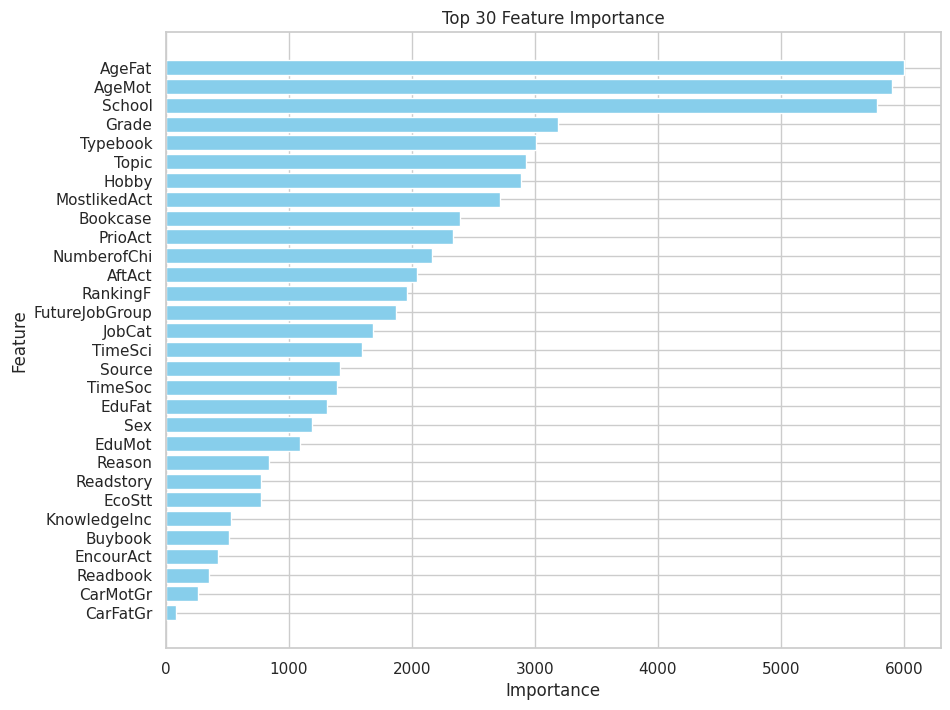

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_table' is your DataFrame with columns 'Feature' and 'Importance'
# Sort the DataFrame by 'Importance' in descending order and select the top 15 features
top_30_features = feature_importance_table.sort_values(by='Importance', ascending=False).head(30)

# Plotting the bar chart for the top 15 features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


The model evaluation revealed that parental ages are surprisingly strong predictors of student performance, with both mother's and father's ages emerging as key factors. School-related numerical variables, particularly previous grades level, also showed significant predictive power. The dominance of quantitative measures over categorical variables suggests that focusing on these metrics could help educators more accurately identify students in specific level who may need additional support. The school's influence on performance highlights how institutional factors play a crucial role in academic outcomes, pointing to the potential impact of school-level interventions.

## Model with High features selection

To test if the accuracy will improve, choose 3 highest features from the Feature importances graph: Age father, Age mother and School.

In [ ]:
# Subset the data
X_train_selected = X_train[['AgeFat', 'School', 'AgeMot']]

In [ ]:
X_test_selected = X_test[['AgeFat', 'School', 'AgeMot']]

In [ ]:
# Retrain the model with selected features
model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=10)
model.fit(X_train_selected, y_train)

# Evaluate on the test set
accuracy = model.score(X_test_selected, y_test)
print(f"Accuracy with Selected Features: {accuracy:.4f}")

Accuracy with Selected Features: 0.3692


In [ ]:
# Define the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
lgbm_classifier = LGBMClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()

# Define parameter grids for GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multi:softprob'],  # Multiclass classification with probabilities
    'eval_metric': ['mlogloss']
}

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multiclass'],
    'num_class': [4],
    'metric': ['multi_logloss'],
}

knn_param_grid = {
    'n_neighbors': [4, 6, 8],
    'weights': ['uniform', 'distance']
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with each classifier
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=skf, scoring='f1_micro')
rf_grid_search.fit(X_train_selected, y_train)

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=skf, scoring='f1_micro')
xgb_grid_search.fit(X_train_selected, y_train)

lgbm_grid_search = GridSearchCV(lgbm_classifier, lgbm_param_grid, cv=skf, scoring='f1_micro')
lgbm_grid_search.fit(X_train_selected, y_train)

knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=skf, scoring='f1_micro')
knn_grid_search.fit(X_train_selected, y_train)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 6, 8],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

In [ ]:
# Print best parameters and best scores for each classifier
print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Score:", rf_grid_search.best_score_)

print("XGBoost - Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost - Best Score:", xgb_grid_search.best_score_)

print("LightGBM - Best Parameters:", lgbm_grid_search.best_params_)
print("LightGBM - Best Score:", lgbm_grid_search.best_score_)

print("KNN - Best Parameters:", knn_grid_search.best_params_)
print("KNN - Best Score:", knn_grid_search.best_score_)

Random Forest - Best Parameters: {'max_depth': 6, 'n_estimators': 100}
Random Forest - Best Score: 0.3569982415284444
XGBoost - Best Parameters: {'eval_metric': 'mlogloss', 'max_depth': 6, 'n_estimators': 100, 'objective': 'multi:softprob'}
XGBoost - Best Score: 0.3371097698144892
LightGBM - Best Parameters: {'max_depth': 6, 'metric': 'multi_logloss', 'n_estimators': 100, 'num_class': 4, 'objective': 'multiclass'}
LightGBM - Best Score: 0.34794163775485953
KNN - Best Parameters: {'n_neighbors': 8, 'weights': 'uniform'}
KNN - Best Score: 0.3086516800532294


In [ ]:
# Get predictions on the test data
rf_pred = rf_grid_search.predict(X_test_selected)
xgb_pred = xgb_grid_search.predict(X_test_selected)
lgbm_pred = lgbm_grid_search.predict(X_test_selected)
knn_pred = knn_grid_search.predict(X_test_selected)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.03       151
           1       0.26      0.04      0.07       259
           2       0.36      0.95      0.52       350
           3       0.36      0.03      0.06       234

    accuracy                           0.36       994
   macro avg       0.37      0.26      0.17       994
weighted avg       0.36      0.36      0.22       994



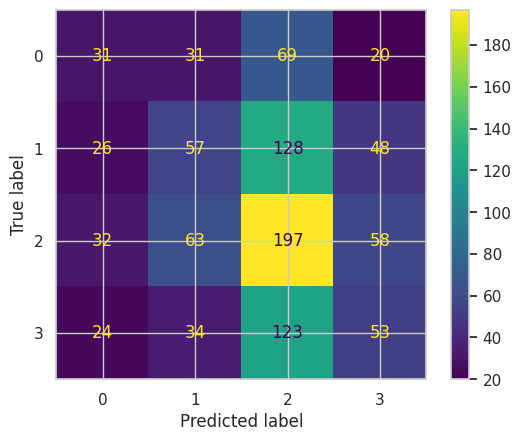

In [ ]:
# Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.23       151
           1       0.31      0.22      0.26       259
           2       0.38      0.56      0.45       350
           3       0.30      0.23      0.26       234

    accuracy                           0.34       994
   macro avg       0.31      0.30      0.30       994
weighted avg       0.33      0.34      0.32       994



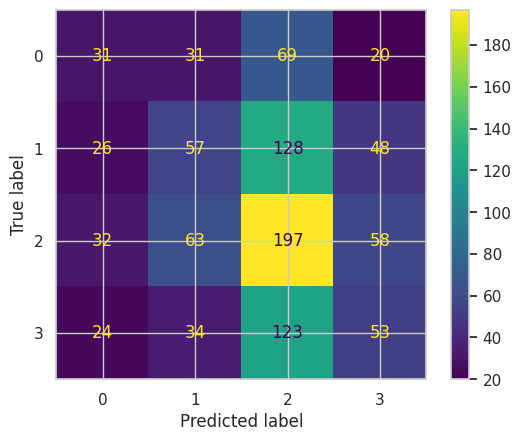

In [ ]:
# XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.18      0.22       151
           1       0.32      0.18      0.23       259
           2       0.36      0.62      0.46       350
           3       0.31      0.20      0.24       234

    accuracy                           0.34       994
   macro avg       0.32      0.30      0.29       994
weighted avg       0.33      0.34      0.31       994



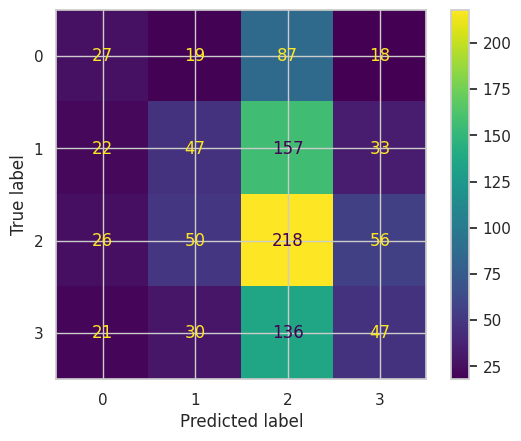

In [ ]:
# LightGBM
print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lgbm_pred)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.25      0.24       151
           1       0.31      0.27      0.29       259
           2       0.39      0.52      0.44       350
           3       0.31      0.19      0.23       234

    accuracy                           0.34       994
   macro avg       0.31      0.31      0.30       994
weighted avg       0.33      0.34      0.32       994



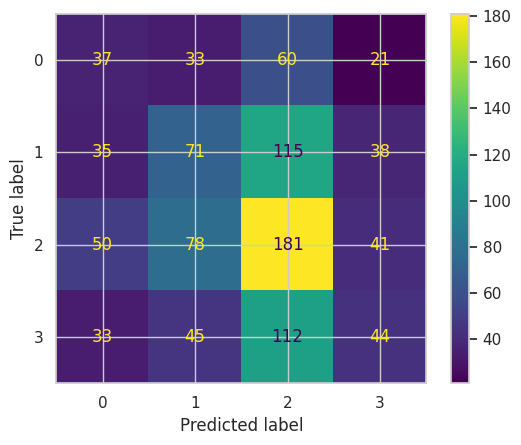

In [ ]:
# KNN
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

# Summary results

The machine learning models evaluated included KNN, Random Forest, LightGBM, and XGBoost, with Random Forest emerging as the most promising model based on overall accuracy metrics. The feature importance analysis revealed that parental ages and previous grade levels were unexpectedly strong predictors of STEM performance. The Random Forest model achieved the highest accuracy among all tested models, though with an interesting discrepancy between accuracy and F1-score metrics that suggests potential class imbalance issues.

The comparative analysis showed that models generally performed better with the complete feature set rather than using only high-importance features, indicating the value of comprehensive data in capturing complex educational patterns. The evaluation metrics demonstrated moderate predictive capability, with the Random Forest model achieving approximately 45% accuracy, suggesting room for further refinement while still providing valuable insights for educational decision-making.
